# Visualising a Convolutional Neural Network

In [1]:
# general data and misc libraries
import pandas as pd
import numpy as np
from collections import OrderedDict`
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# set default colour map to use
plt.rcParams['image.cmap'] = 'Reds'

# tensorflow/keras for cnn training
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

# sklearn component analysis and utilities
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [2]:
# height (rows) and width (columns) of images in pixels 
img_rows, img_cols = 28, 28
# no. of classes to identify in images
num_classes = 10

# load training data
df = pd.read_csv('train.csv')
print('Shape of data file:',df.shape)

# get data excluding label column
X = df.drop('label',axis=1)
# reconstruct images from flattened rows
X = X.values.reshape(len(X),img_rows,img_cols,1)
# normalise X to lie between 0 and 1
X = X/X.max()
print('Shape of network input:',X.shape)

# extract true label of each image
labels = df.label.values
# convert labels in to dummy vectors
y = keras.utils.to_categorical(labels, num_classes)
print('Shape of label vectors:',y.shape)
print('First label vector:',y[0])

# don't need the original data frame anymore
# delete it to save a bit of memory
del df

Shape of data file: (42000, 785)
Shape of network input: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


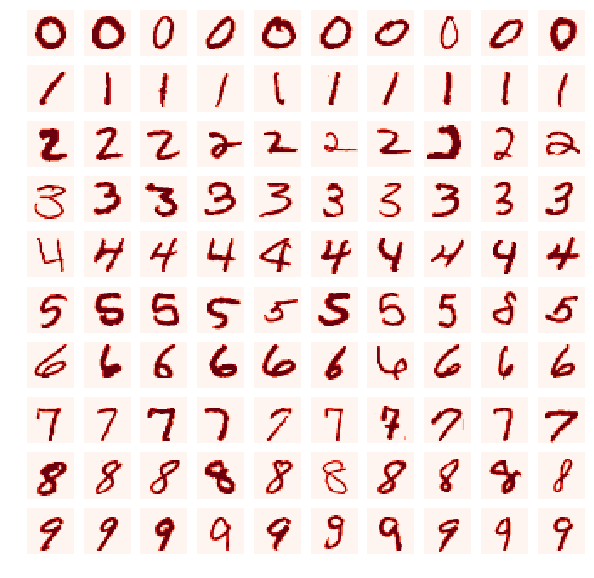

In [3]:
# plot 1st 10 images of each class
plt.figure(figsize=(10,num_classes))

for i in range(num_classes):
    # select images in class i
    tmp = X[y[:,i]==1]
    
    # display 1st 10 images in class i
    for j in range(10):
        plt.subplot(num_classes,10,(10*i)+(j+1))
        plt.imshow(tmp[j][:,:,0])
        
        # use the same colour range for each image
        plt.clim(0,1)
        # don't show axes
        plt.axis('off')

In [4]:
# Define layers to include in the network
layers = OrderedDict({
          ######################################################
          # DEFINE NETWORK LAYERS, EXCLUDING OUTPUT LAYER.
          # KEY AND GIVEN NAME ARGUMENT MUST BE THE SAME.
          ######################################################          
          'Conv1': Conv2D(10, kernel_size=(5, 5), 
                          activation='relu',name='Conv1',
                          input_shape=(img_rows, img_cols, 1)),
          'Conv2': Conv2D(15, kernel_size=(5, 5), 
                          activation='relu',name='Conv2'),
          'Conv3': Conv2D(20, kernel_size=(3, 3), 
                          activation='relu',name='Conv3'),  
          'Conv4': Conv2D(25, kernel_size=(3, 3), 
                          activation='relu',name='Conv4'),    
          'Pool1': MaxPool2D(pool_size=(2, 2), strides=2,
                          name='Pool1'),
          'Flatten': Flatten(name='Flatten'),
          'Dense1': Dense(50, activation='relu',name='Dense1'),   
          ######################################################
          # PLEASE DO NOT CHANGE OUTPUT LAYER
          'Output': Dense(num_classes, activation='softmax',
                          name='Output')
          ######################################################
        })

# no. layers in defined network
n_layers = len(layers)

# Buld model
model = Sequential()

# add each defined layer to the model
for key,layer in layers.items():
    model.add(layer)

# set model optimisation parameters
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X, y,
          batch_size=100,
          epochs=6,
          validation_split = 0.2)


Train on 33600 samples, validate on 8400 samples
Epoch 1/6
33600/33600 [==============================] - 154s 5ms/step - loss: 0.3021 - acc: 0.9079 - val_loss: 0.0976 - val_acc: 0.9685
Epoch 2/6
33600/33600 [==============================] - 141s 4ms/step - loss: 0.0795 - acc: 0.9757 - val_loss: 0.0605 - val_acc: 0.9796
Epoch 3/6
33600/33600 [==============================] - 110s 3ms/step - loss: 0.0581 - acc: 0.9831 - val_loss: 0.0571 - val_acc: 0.9824
Epoch 4/6
33600/33600 [==============================] - 110s 3ms/step - loss: 0.0426 - acc: 0.9868 - val_loss: 0.0609 - val_acc: 0.9811
Epoch 5/6
33600/33600 [==============================] - 111s 3ms/step - loss: 0.0347 - acc: 0.9894 - val_loss: 0.0440 - val_acc: 0.9875
Epoch 6/6
33600/33600 [==============================] - 109s 3ms/step - loss: 0.0293 - acc: 0.9906 - val_loss: 0.0487 - val_acc: 0.9869


In [5]:
# Calculate representation of the image in each layer
# of the network.

# maximum no. filters in any convolutional layer, used to define figure sizes later
# initialise at 9 (min fig size), overwrite in loop if a layer has more than 9
max_filters = 9

layer_out = OrderedDict({})
prev_layer_out = None

for key in layers.keys():
    # create a model consisting of only the current layer
    layer_model = Sequential()
    layer_model.add(model.get_layer(key))
    
    # if this is the first layer, predict using the input images
    if prev_layer_out is None:
        layer_out[key] = layer_model.predict(X)
    # otherwise, predict using output of previous layer
    else:
        layer_out[key] = layer_model.predict(prev_layer_out)
        
    # check if this is a convolution layer with more filters
    # than the current maximum.
    if layer_out[key].ndim==4:
        n_filters = layer_out[key].shape[-1]
        if n_filters>max_filters:
            max_filters = n_filters
            
    prev_layer_out = layer_out[key]
    
    print(key, 'layer has shape',layer_out[key].shape)

Conv1 layer has shape (42000, 24, 24, 10)
Conv2 layer has shape (42000, 20, 20, 15)
Conv3 layer has shape (42000, 18, 18, 20)
Conv4 layer has shape (42000, 16, 16, 25)
Pool1 layer has shape (42000, 8, 8, 25)
Flatten layer has shape (42000, 1600)
Dense1 layer has shape (42000, 50)
Output layer has shape (42000, 10)


Text(0.5,33,'PREDICTED')

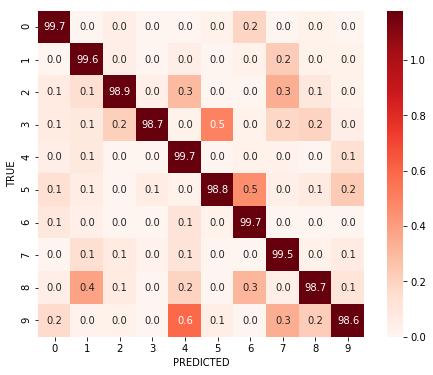

In [123]:
# calculate confusion matrix
cm=confusion_matrix(labels,layer_out['Output'].argmax(axis=1))

# convert to percentages
cm=100*cm/cm.sum(axis=1)

# display
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,square=True,cmap='Reds',fmt='.1f',
            vmax=2*max([np.triu(cm,k=1).max(),np.tril(cm,k=-1).max()]))
# vmax: used to limit range of colour bar to highlight incorrect predictions,
# rather than letting diagonal dominate. Current limit is double the maximum
# incorrect prediction prediction for any number (2*max in upper or lower triangle).
plt.ylabel('TRUE')
plt.xlabel('PREDICTED')

Input...Conv1...Conv2...Conv3...Conv4...Pool1...Flatten...Dense1...Output...Done!


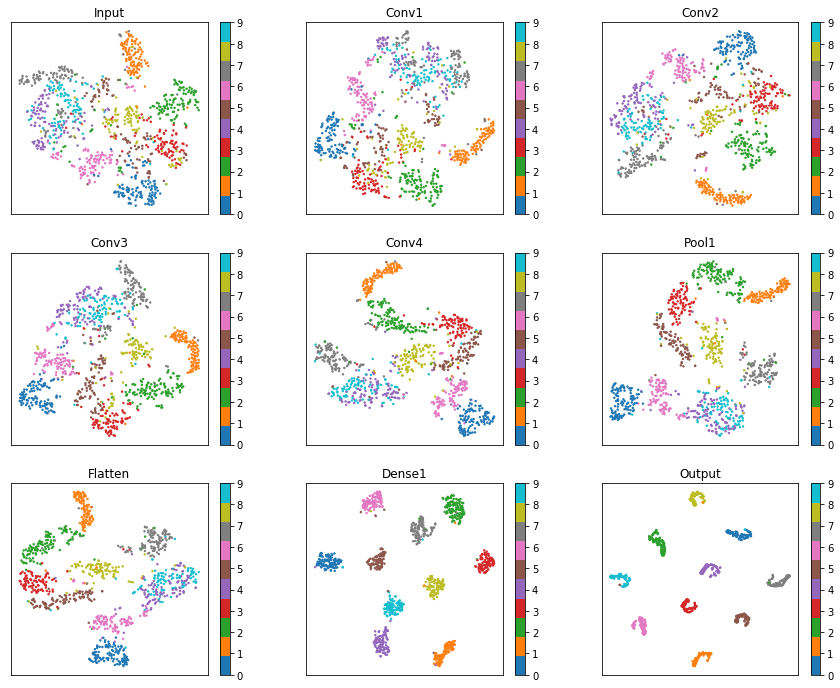

In [7]:
# t-sne to see distinction between digits at different layers
def tsne_layers(img_ids):
    # TSNE too computationally expensive to run on data with many features.
    # First use PCA to extract the first num_classes components, then follow with TSNE.
    pipe = Pipeline([('pca',PCA(n_components=num_classes)),('tsne',TSNE())])

    # make figure
    rows = ceil(np.sqrt(n_layers+1))
    cols = ceil((n_layers+1)/rows)
    plt.figure(figsize=(5*cols,4*rows))
    
    # visualise structure of input 
    i=1
    print('Input...',end='')
    # flatten data
    pipe_in = X[img_ids].reshape([len(img_ids),-1])
    # transform data
    pipe_out = pipe.fit_transform(pipe_in)
    # plot data, with points coloured by class
    plt.subplot(rows,cols,i)
    plt.scatter(pipe_out[:,0],pipe_out[:,1],c=labels[img_ids],cmap='tab10',s=2)
    plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.title('Input')
    i+=1

    # visualise structure of network layers
    for key,out in layer_out.items():
        print(key+'...',end='')
        pipe_in = out[img_ids].reshape([len(img_ids),-1])
        pipe_out = pipe.fit_transform(pipe_in)

        plt.subplot(rows,cols,i)
        plt.scatter(pipe_out[:,0],pipe_out[:,1],c=labels[img_ids],cmap='tab10',s=2)
        plt.xticks([]), plt.yticks([])
        plt.colorbar()
        plt.title(key)
        i+=1
    print('Done!')

# choose a subset of images to use - not practical to calculate
# or visualise all.
img_ids = range(1000)

tsne_layers(img_ids)

In [8]:
# visualise representation of the image in each layer
# of the network.
def plot_network(img_id):
    # no. rows in figure (including extra row for input layer)
    nrows = n_layers+1
    # no. additional columns for text labels
    txtwidth = max([int(max_filters/12),2])
    ncols = max_filters+txtwidth
    # text box/font style
    props = dict(boxstyle='round', facecolor='w')
    fontsize = 1.3*ncols
    # create figure
    plt.figure(figsize=(2*ncols,2*nrows))
   
    ####################
    # input
    ####################
    
    # title
    row = 1
    ax = plt.subplot2grid((nrows, ncols), (0, 0), colspan=txtwidth)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'Input', verticalalignment='center',fontsize=fontsize,bbox=props)
    plt.axis('off')
    
    # show input image
    plt.subplot2grid((nrows, ncols), (0, int((ncols-txtwidth)/2 + 0.5*txtwidth)), colspan=txtwidth)
    plt.imshow(X[img_id][:,:,0])
    plt.clim(0,1)
    plt.axis('off')
    
    # correct label of input image
    ax = plt.subplot2grid((nrows, ncols), (0, txtwidth), colspan=txtwidth)
    plt.plot([0,0],[1,1])
    ax.text(0,1,
            'True label: '+str(y[img_id,:].argmax()),
            verticalalignment='center',horizontalalignment='center',fontsize=fontsize,bbox=props)
    plt.axis('off')

    # predicted label for input image
    ax = plt.subplot2grid((nrows, ncols), (0, ncols-txtwidth-1), colspan=txtwidth)
    plt.plot([0,0],[1,1])
    ax.text(0,1,
            'Predicted: '+
            str(layer_out['Output'][img_id,:].argmax())+
            ' ({:.1f}% probability)'.format(100*layer_out['Output'][img_id,:].max()),
            verticalalignment='center',horizontalalignment='center',
            fontsize=fontsize,bbox=props)
    plt.axis('off')

    #######################
    # remaining layers
    #######################
    
    for key in layer_out.keys():
        row += 1
        
        # layer title
        ax = plt.subplot2grid((nrows, ncols), (row-1, 0), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0, 1, key, verticalalignment='center',fontsize=fontsize,bbox=props)
        plt.axis('off')
        
        # annotated heatmap for output layer
        if key is 'Output':
            plt.subplot2grid((nrows, ncols), (row-1, txtwidth+1), colspan=ncols-txtwidth-1)
            sns.heatmap(layer_out[key][img_id,:].reshape([1,-1])*100,
                        annot=True,annot_kws={"size": fontsize},fmt='.1f',
                        cmap=plt.rcParams['image.cmap'],cbar=False)
            plt.yticks([])
            plt.xticks(fontsize=fontsize)
            
        # plot image representation for convolutional layers (4 dimensions: image, row, column, filter)
        elif layer_out[key].ndim==4:
            # no. filters in layer
            n_filters = layer_out[key].shape[-1]
            # no. subplots each filter spans in this layer
            nsub_per_filt = max_filters/n_filters
            # plot each filter
            for i in range(n_filters):
                plt.subplot2grid((nrows, ncols), (row-1, txtwidth+int(i*nsub_per_filt)), colspan=int(nsub_per_filt))
                plt.imshow(layer_out[key][img_id,:,:,i])
                plt.axis('off')
                
        # 1d image plot for flattened layers (e.g. dense)
        else:
            n_filters = layer_out[key].shape[-1]
            
            plt.subplot2grid((nrows, ncols), (row-1, txtwidth), colspan=ncols-txtwidth)
            plt.imshow(layer_out[key][img_id,:].reshape(1,n_filters),aspect=max([n_filters/20,1]))
            plt.axis('off')

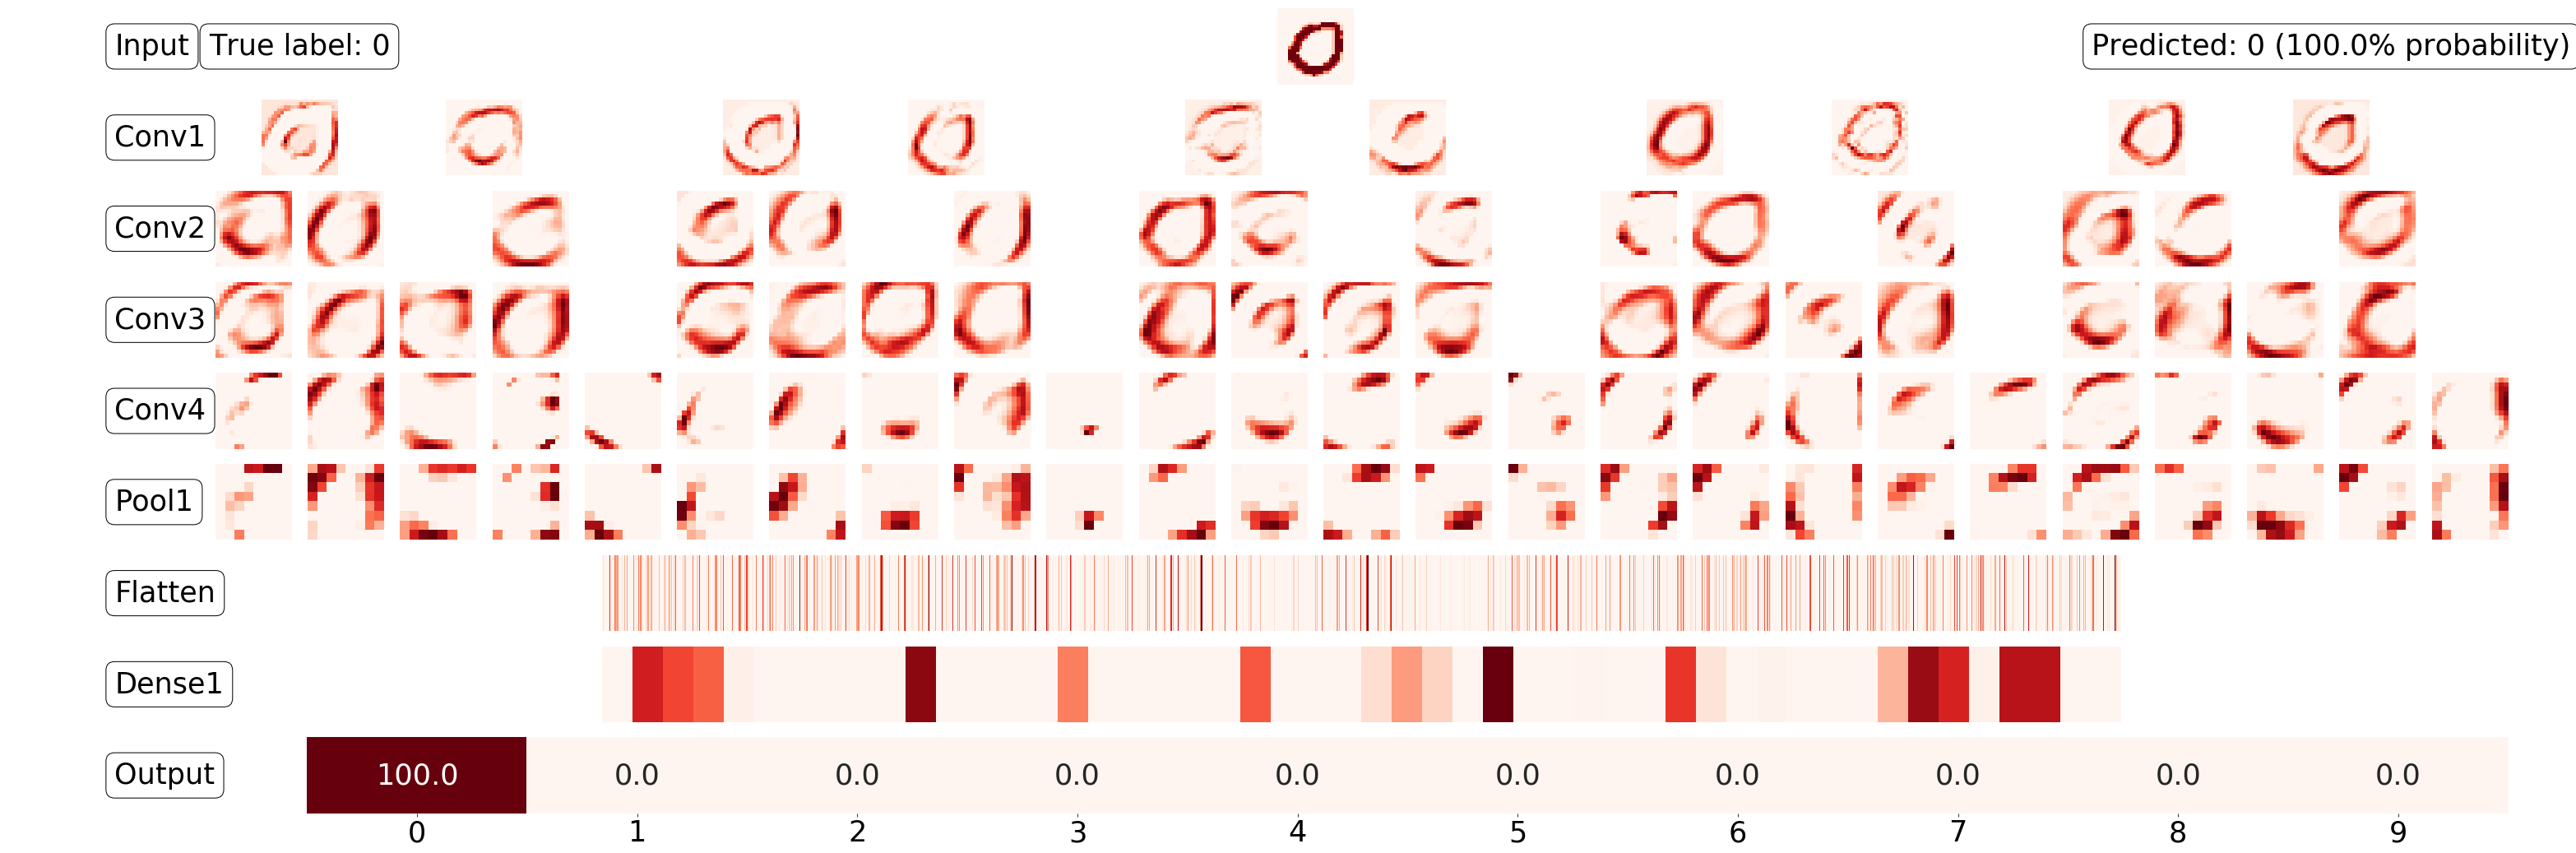

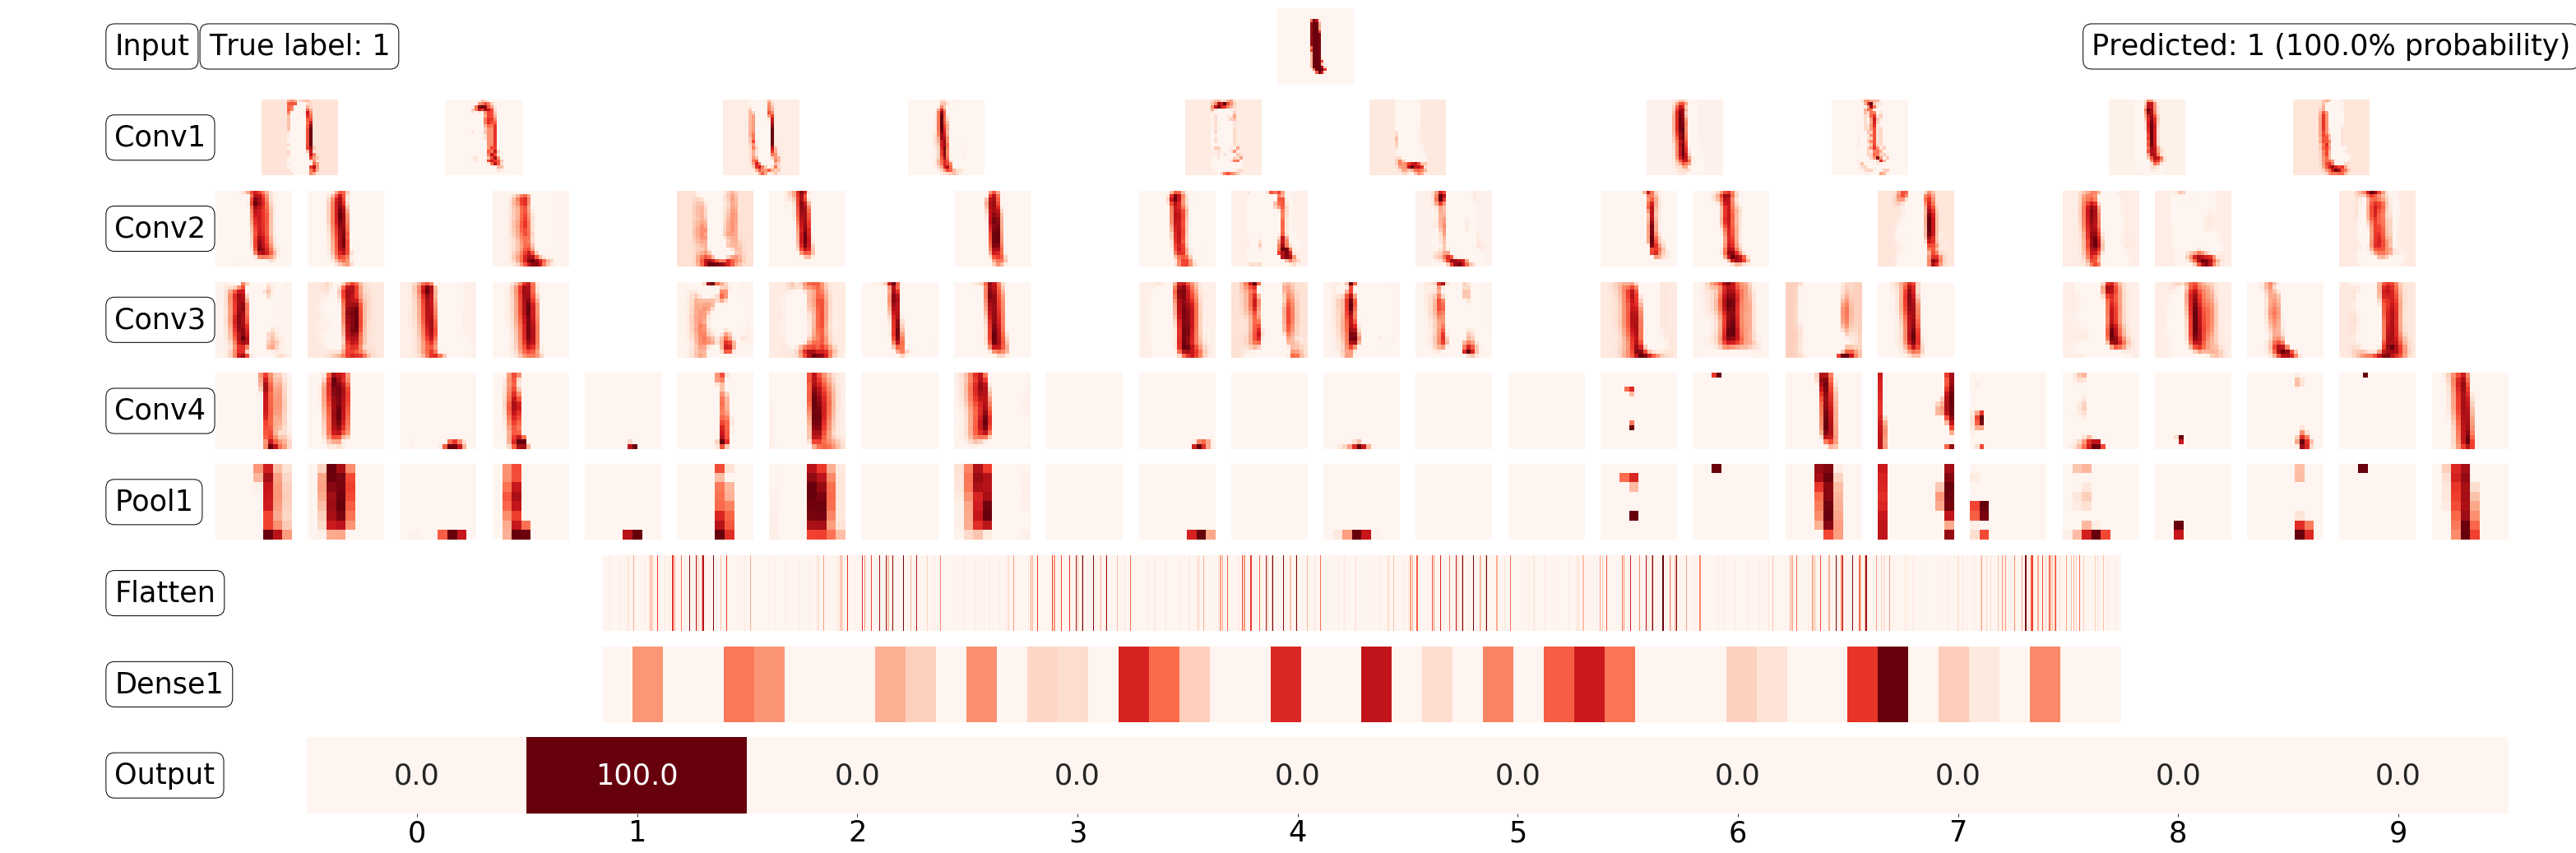

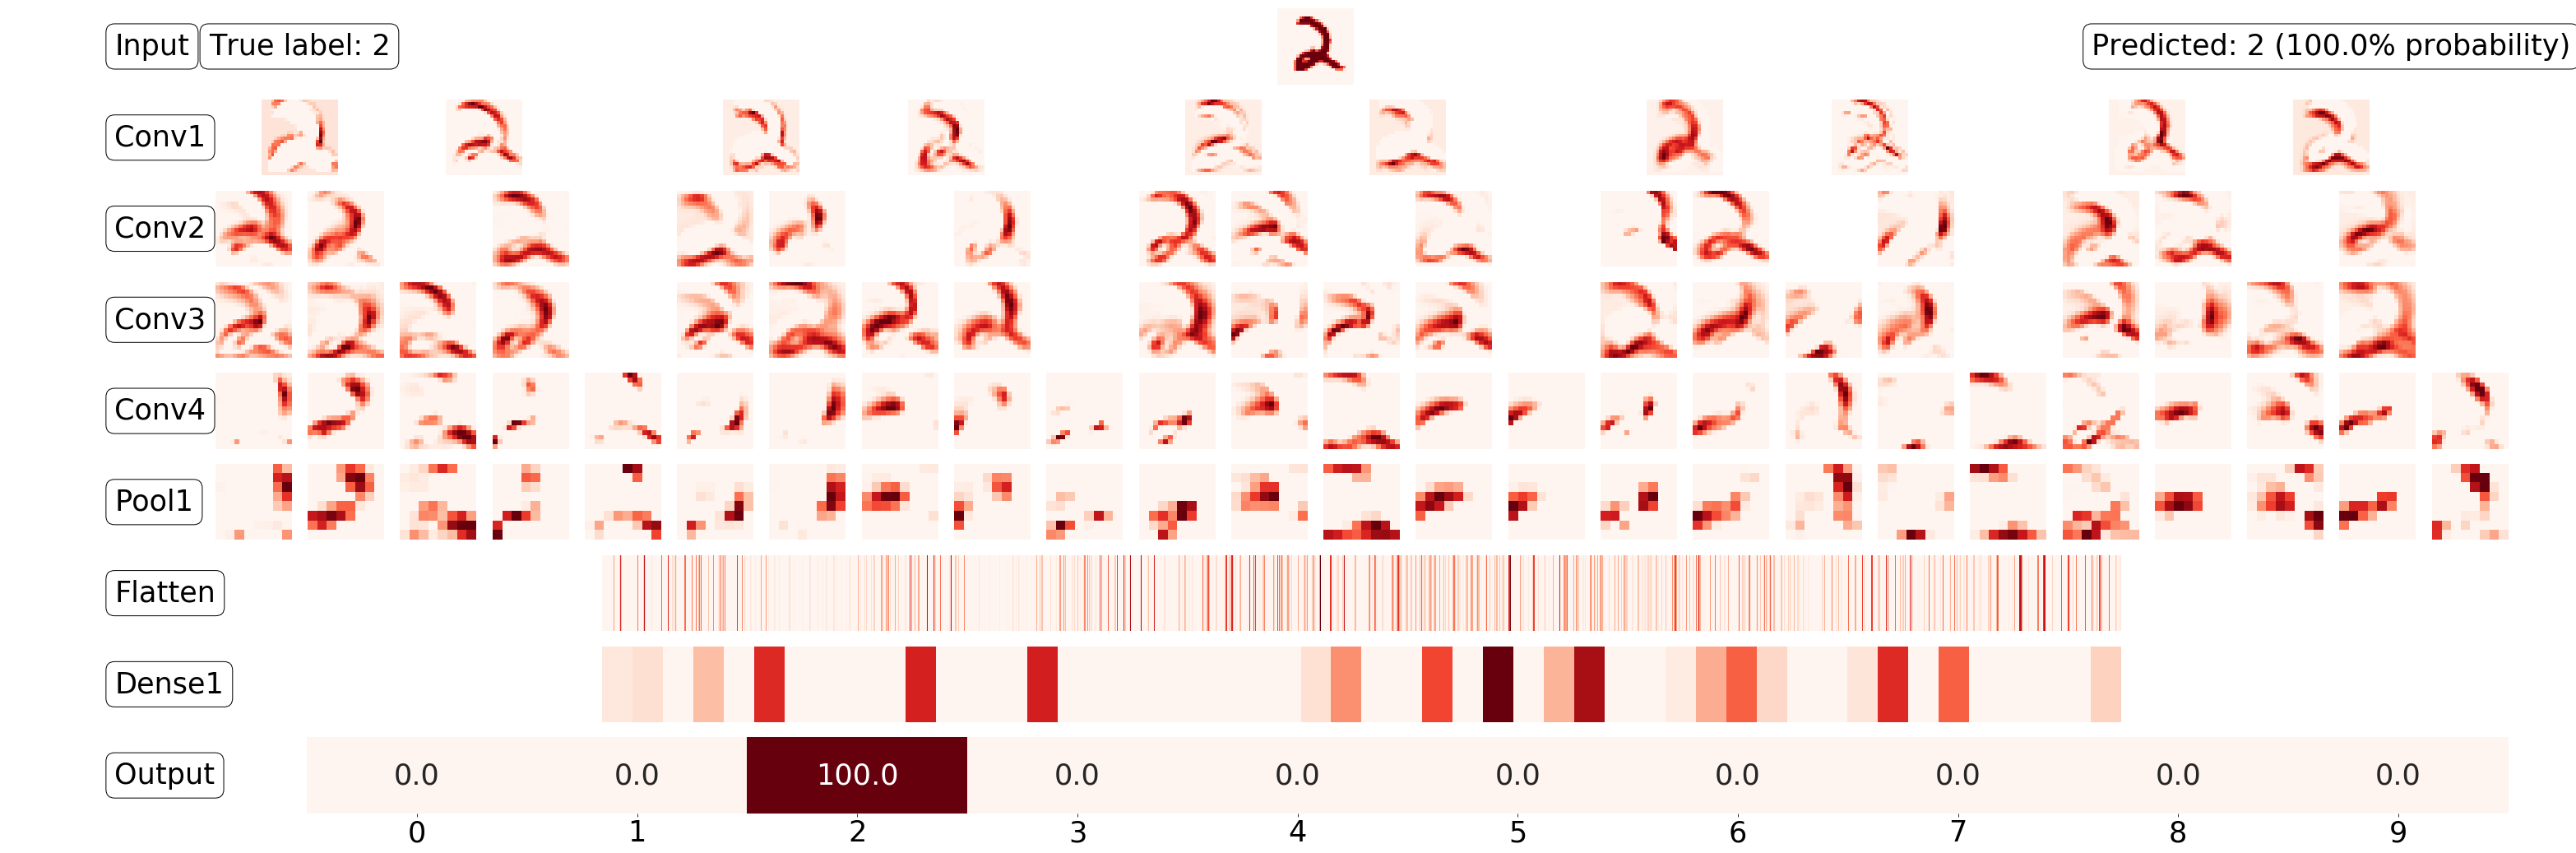

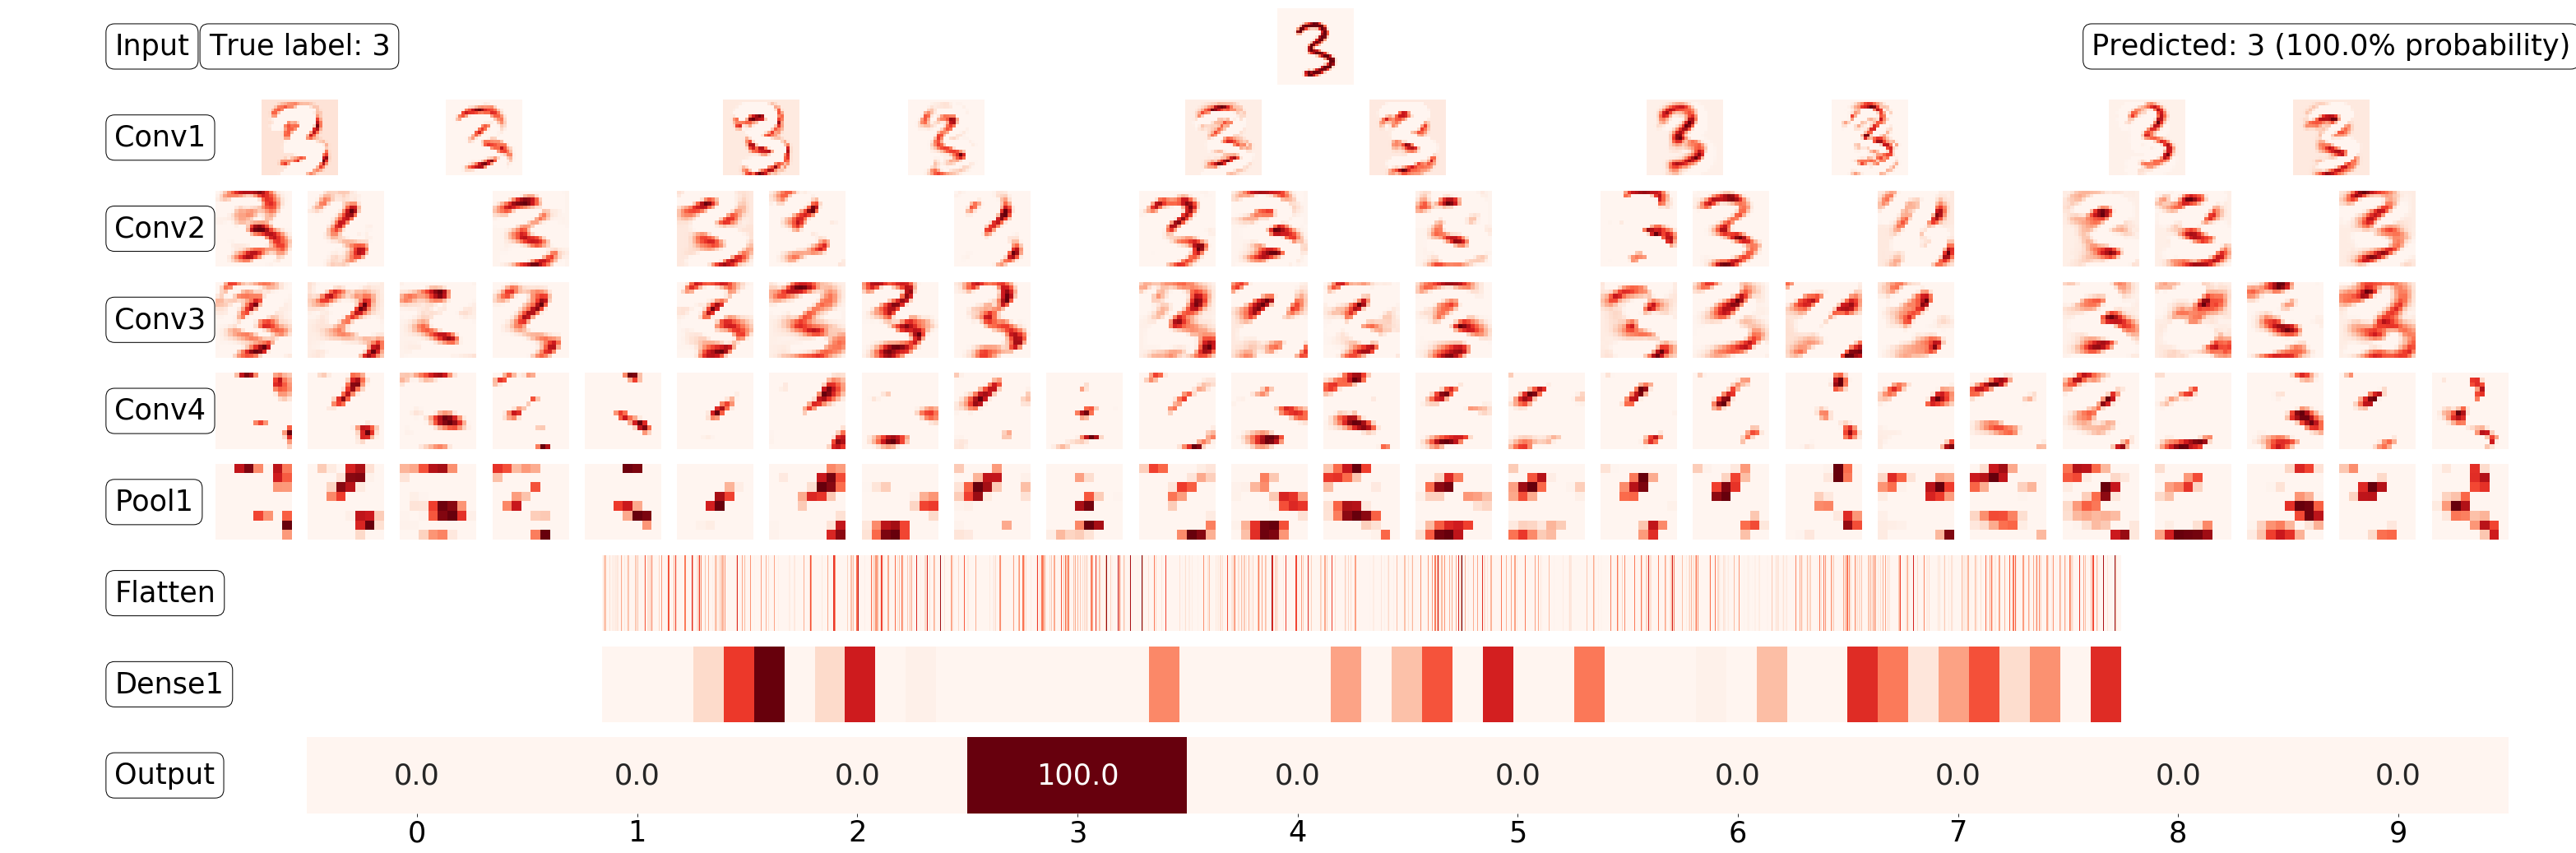

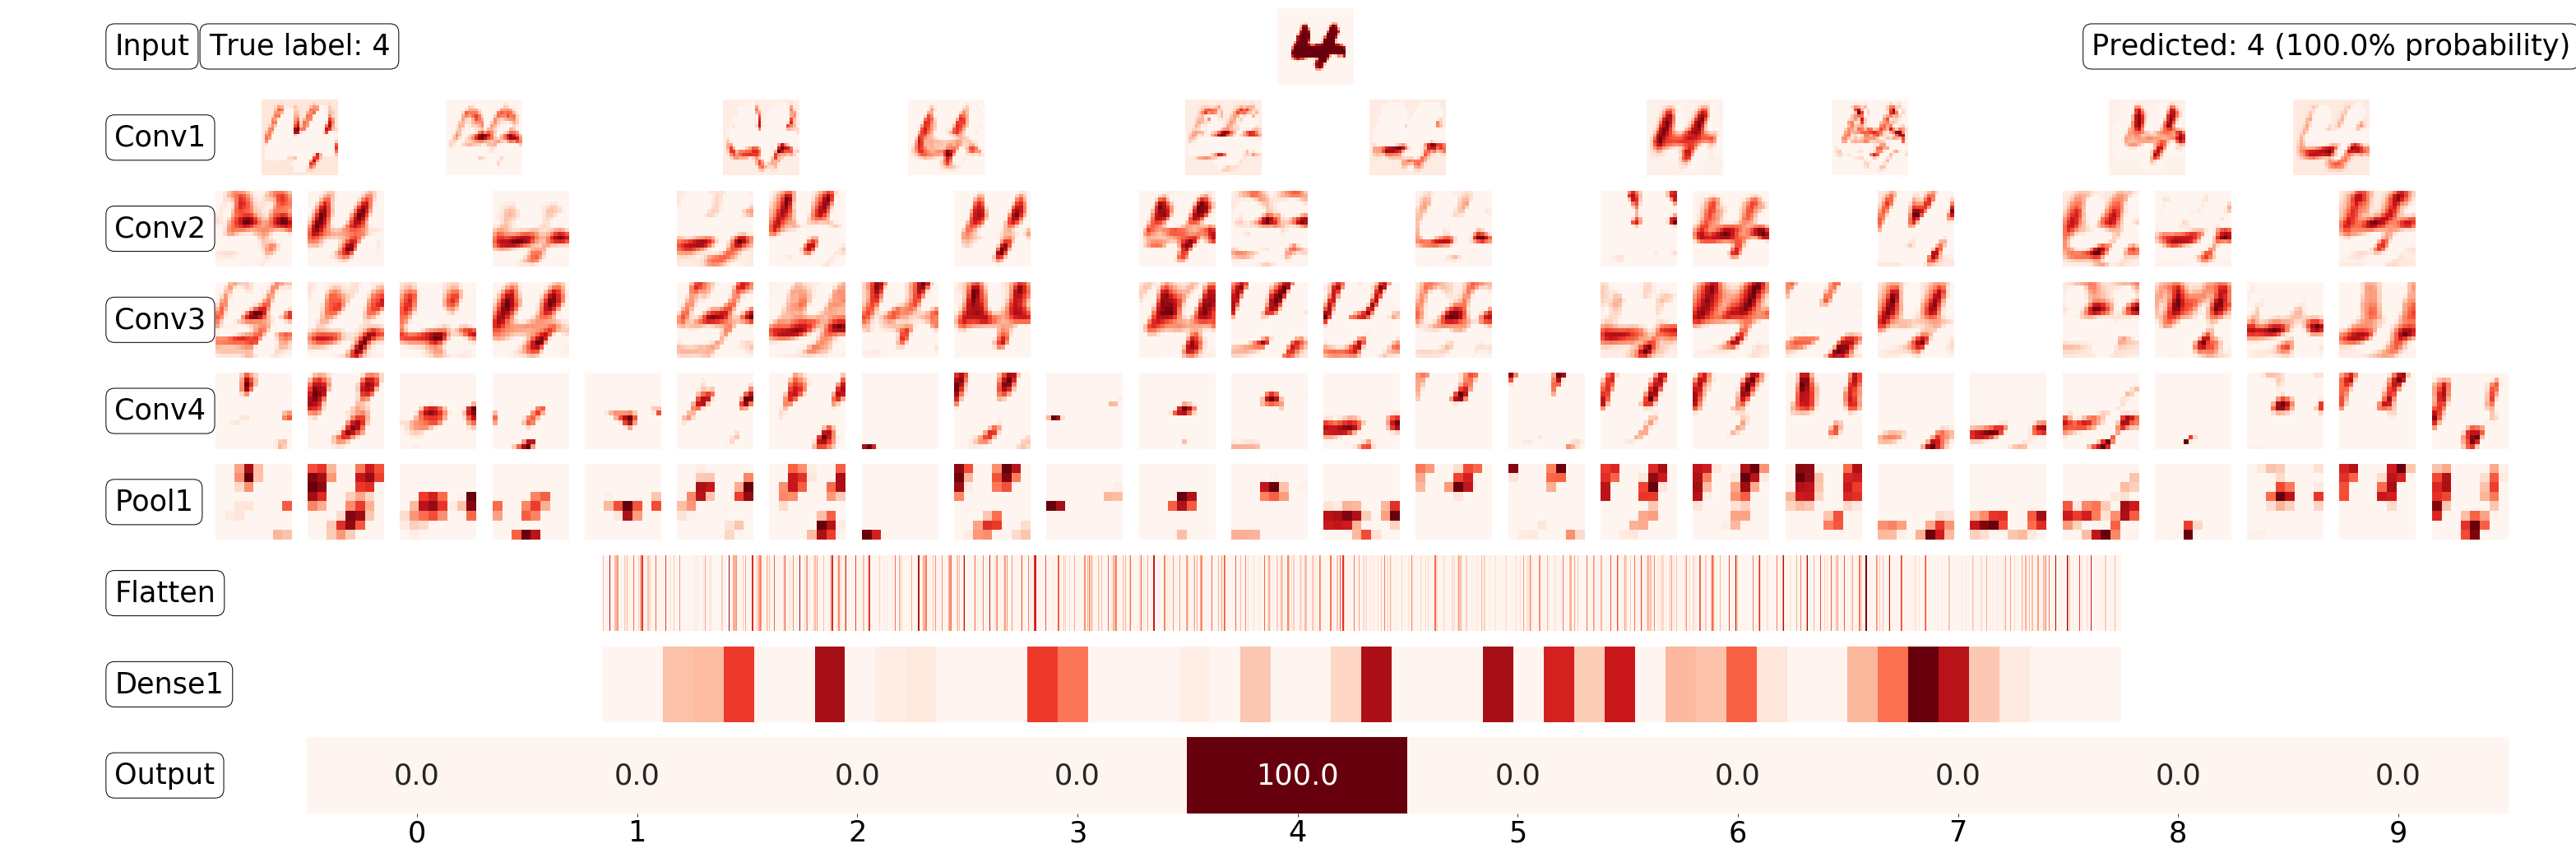

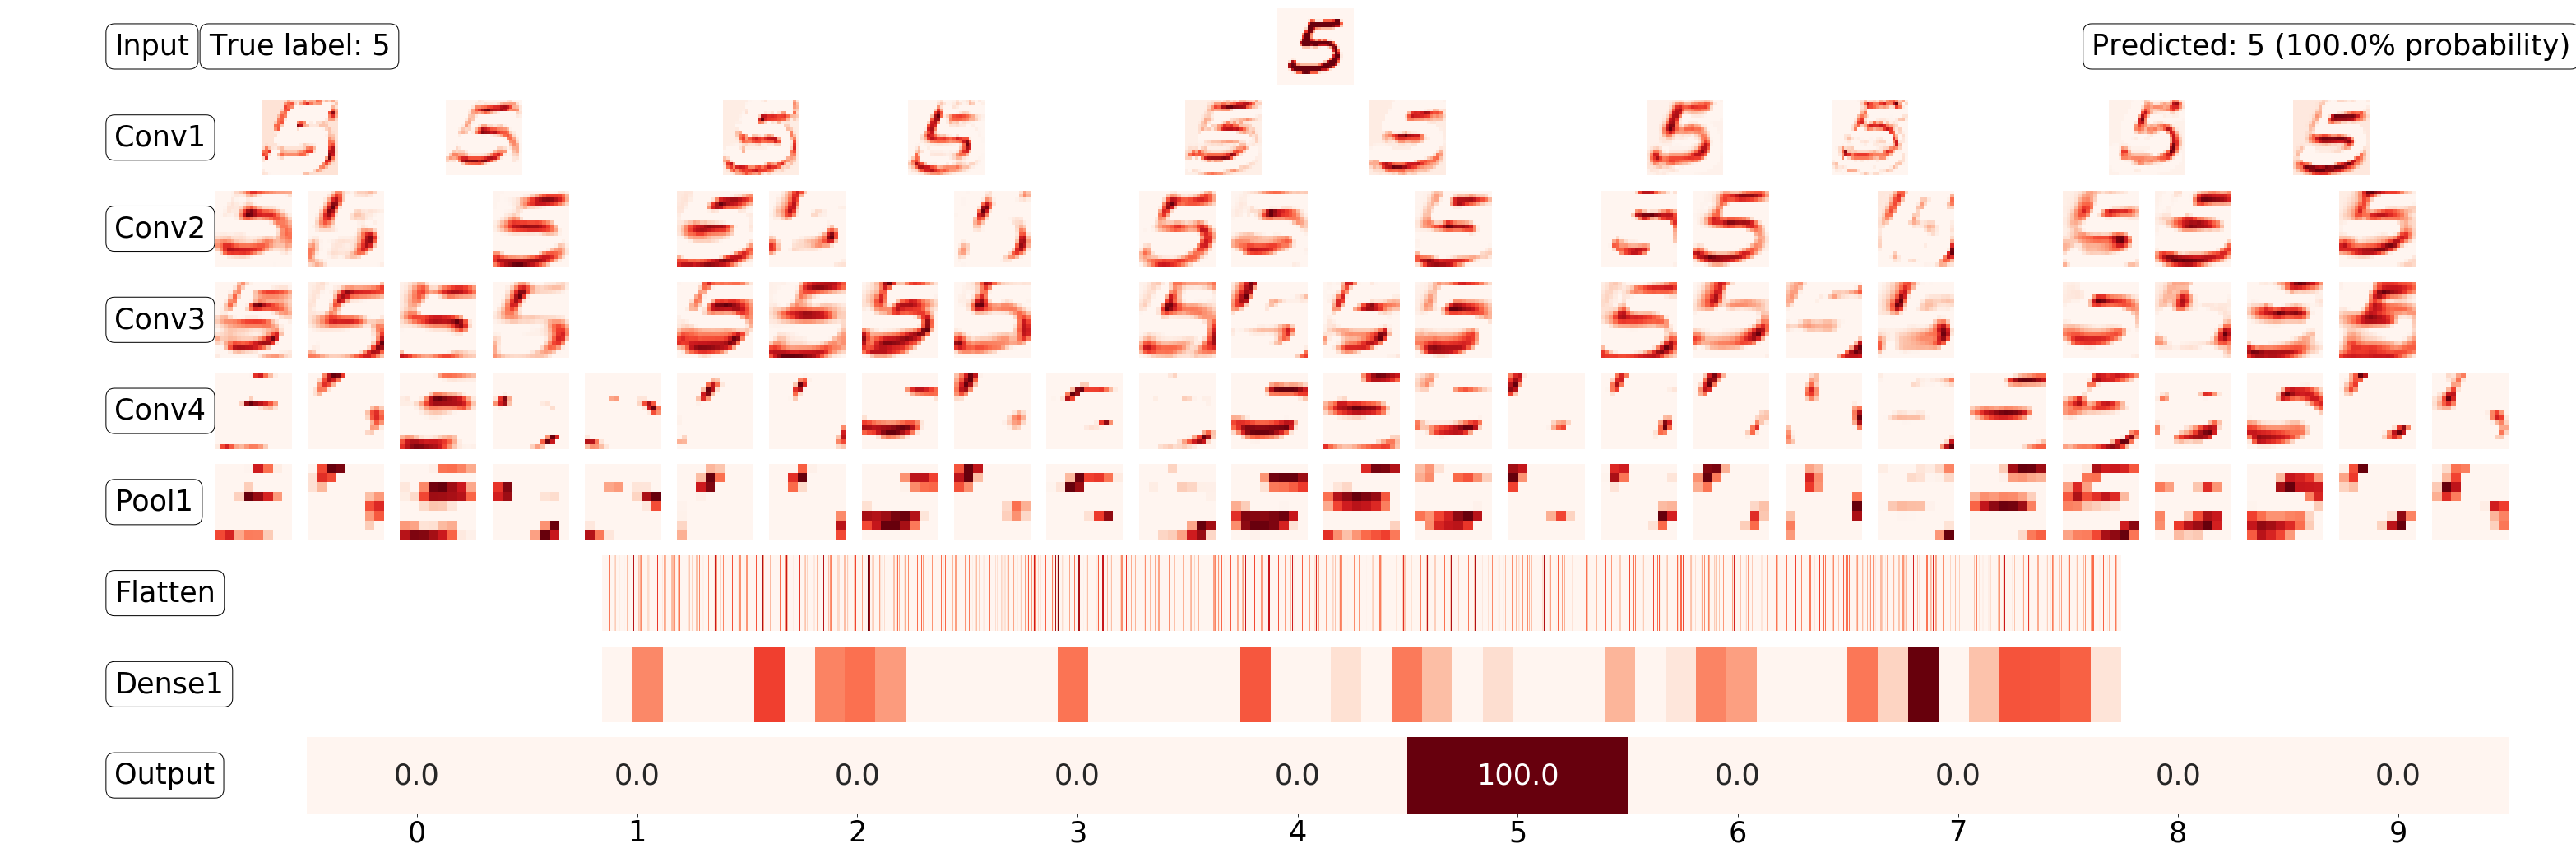

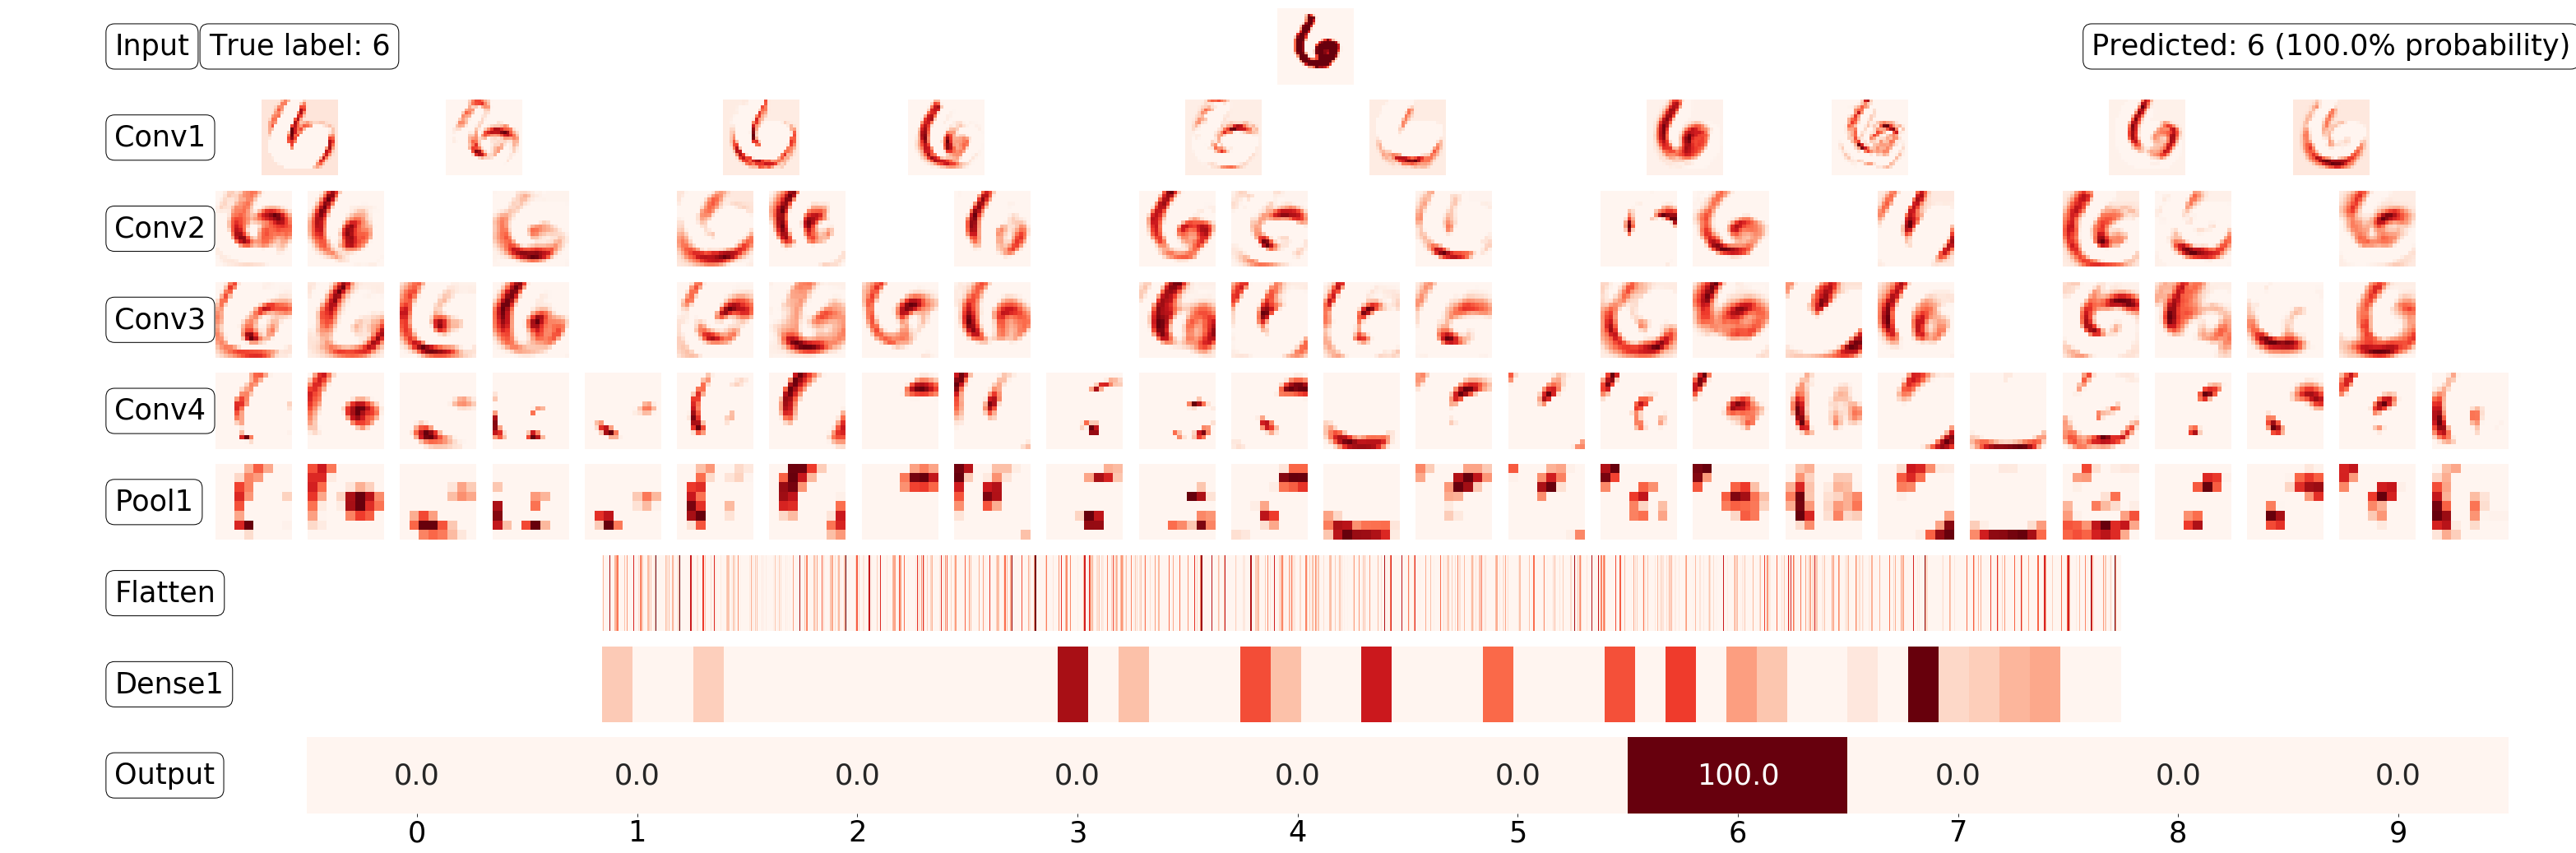

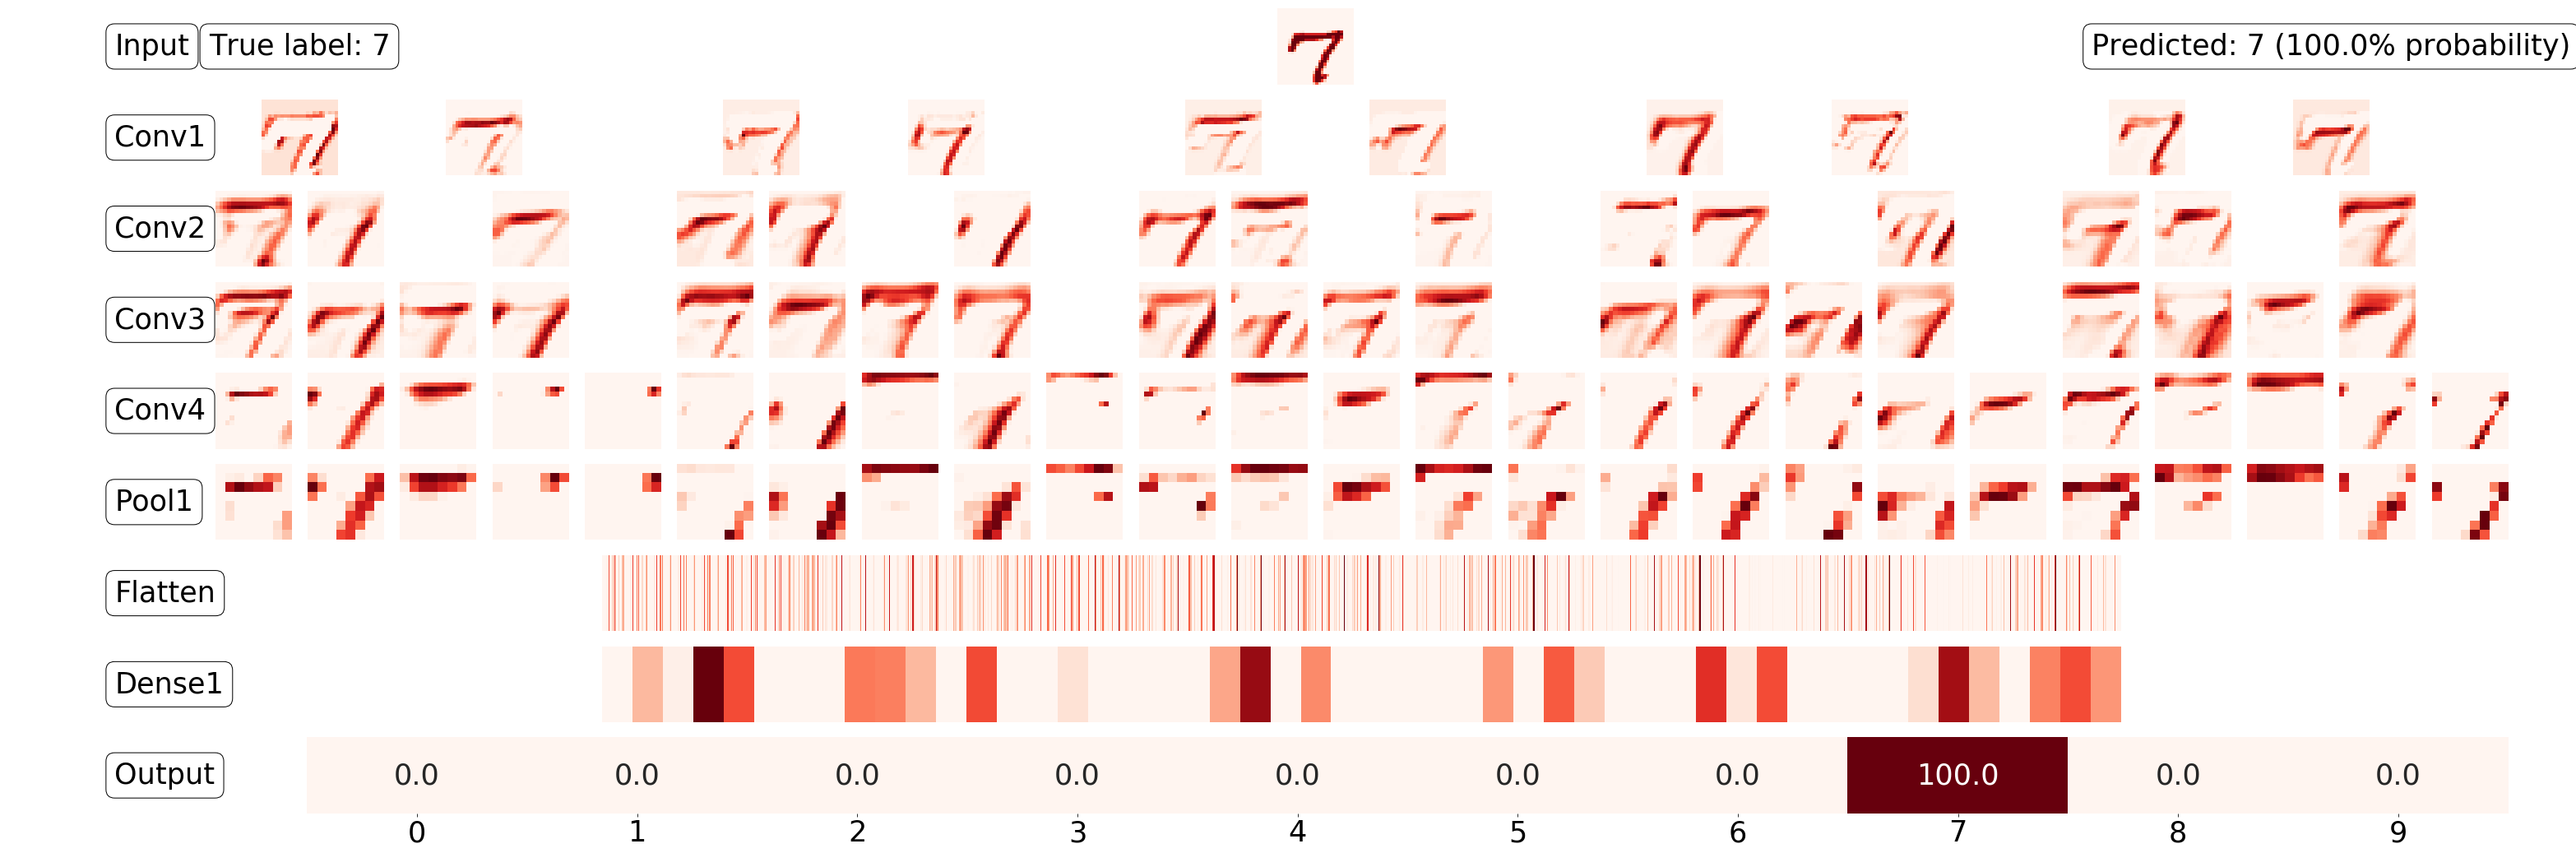

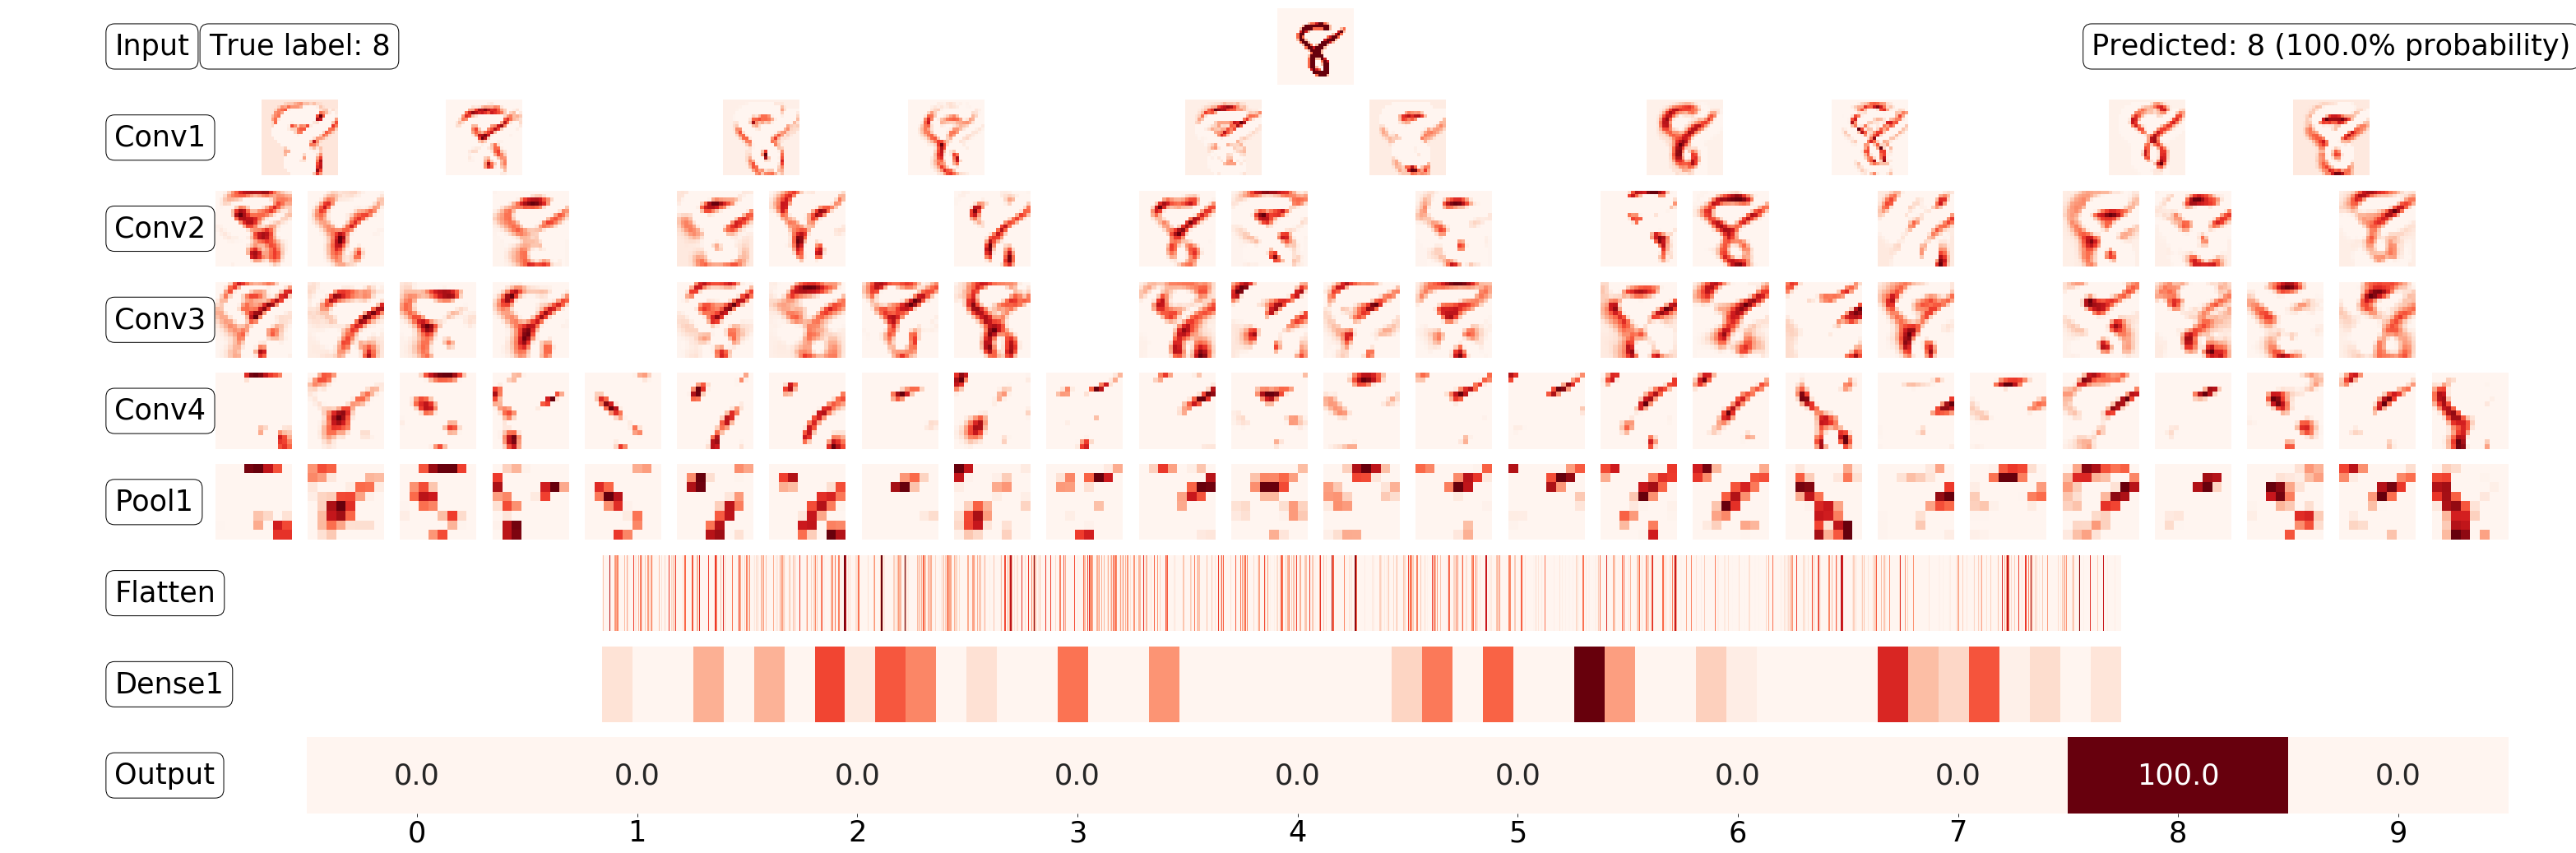

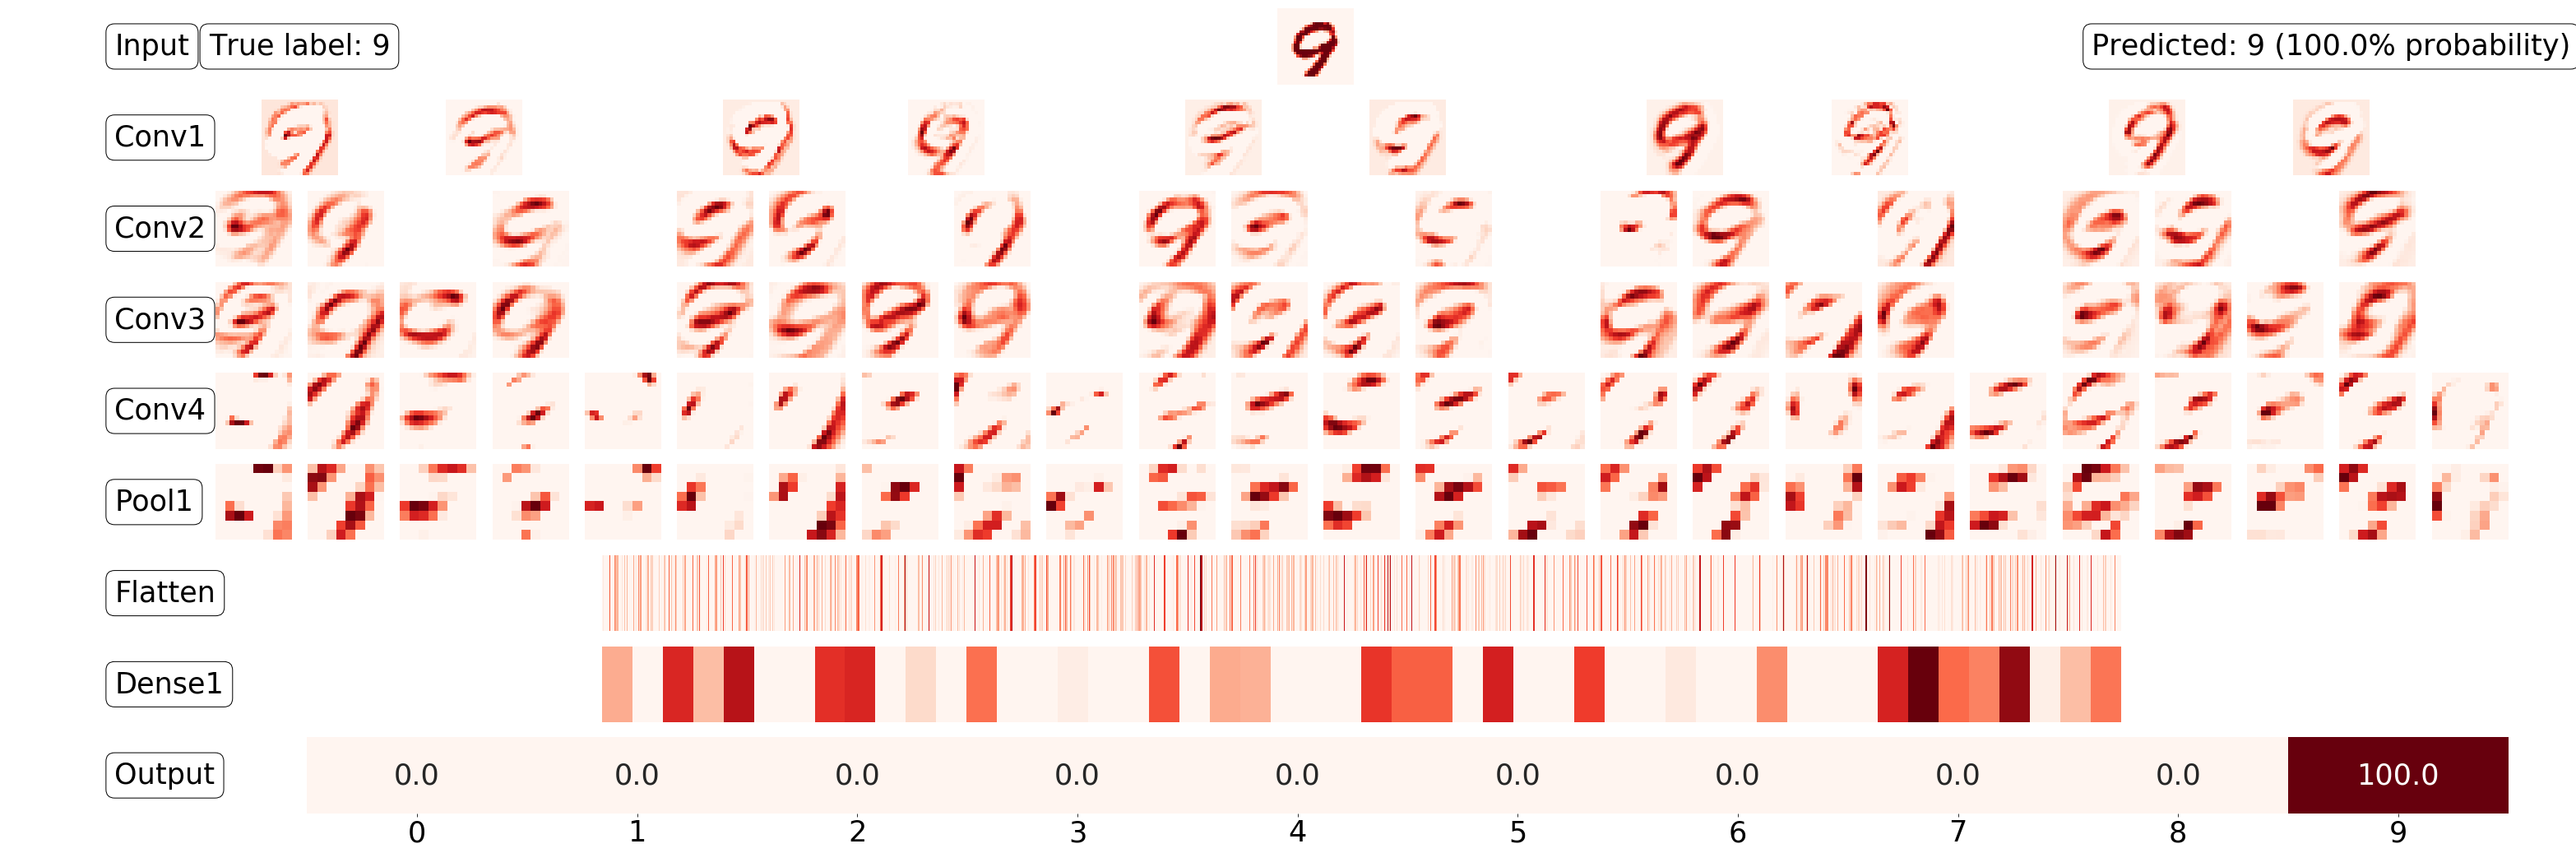

In [58]:
# probability network assigns to correct label for each image
true_prob = pd.Series([layer_out['Output'][i,labels[i]] for i in range(len(labels))])

# visualise image in each class that network predicts most accurately
for i in range(num_classes):
    plot_network(true_prob[labels==i].sort_values(ascending=False).index[0])   

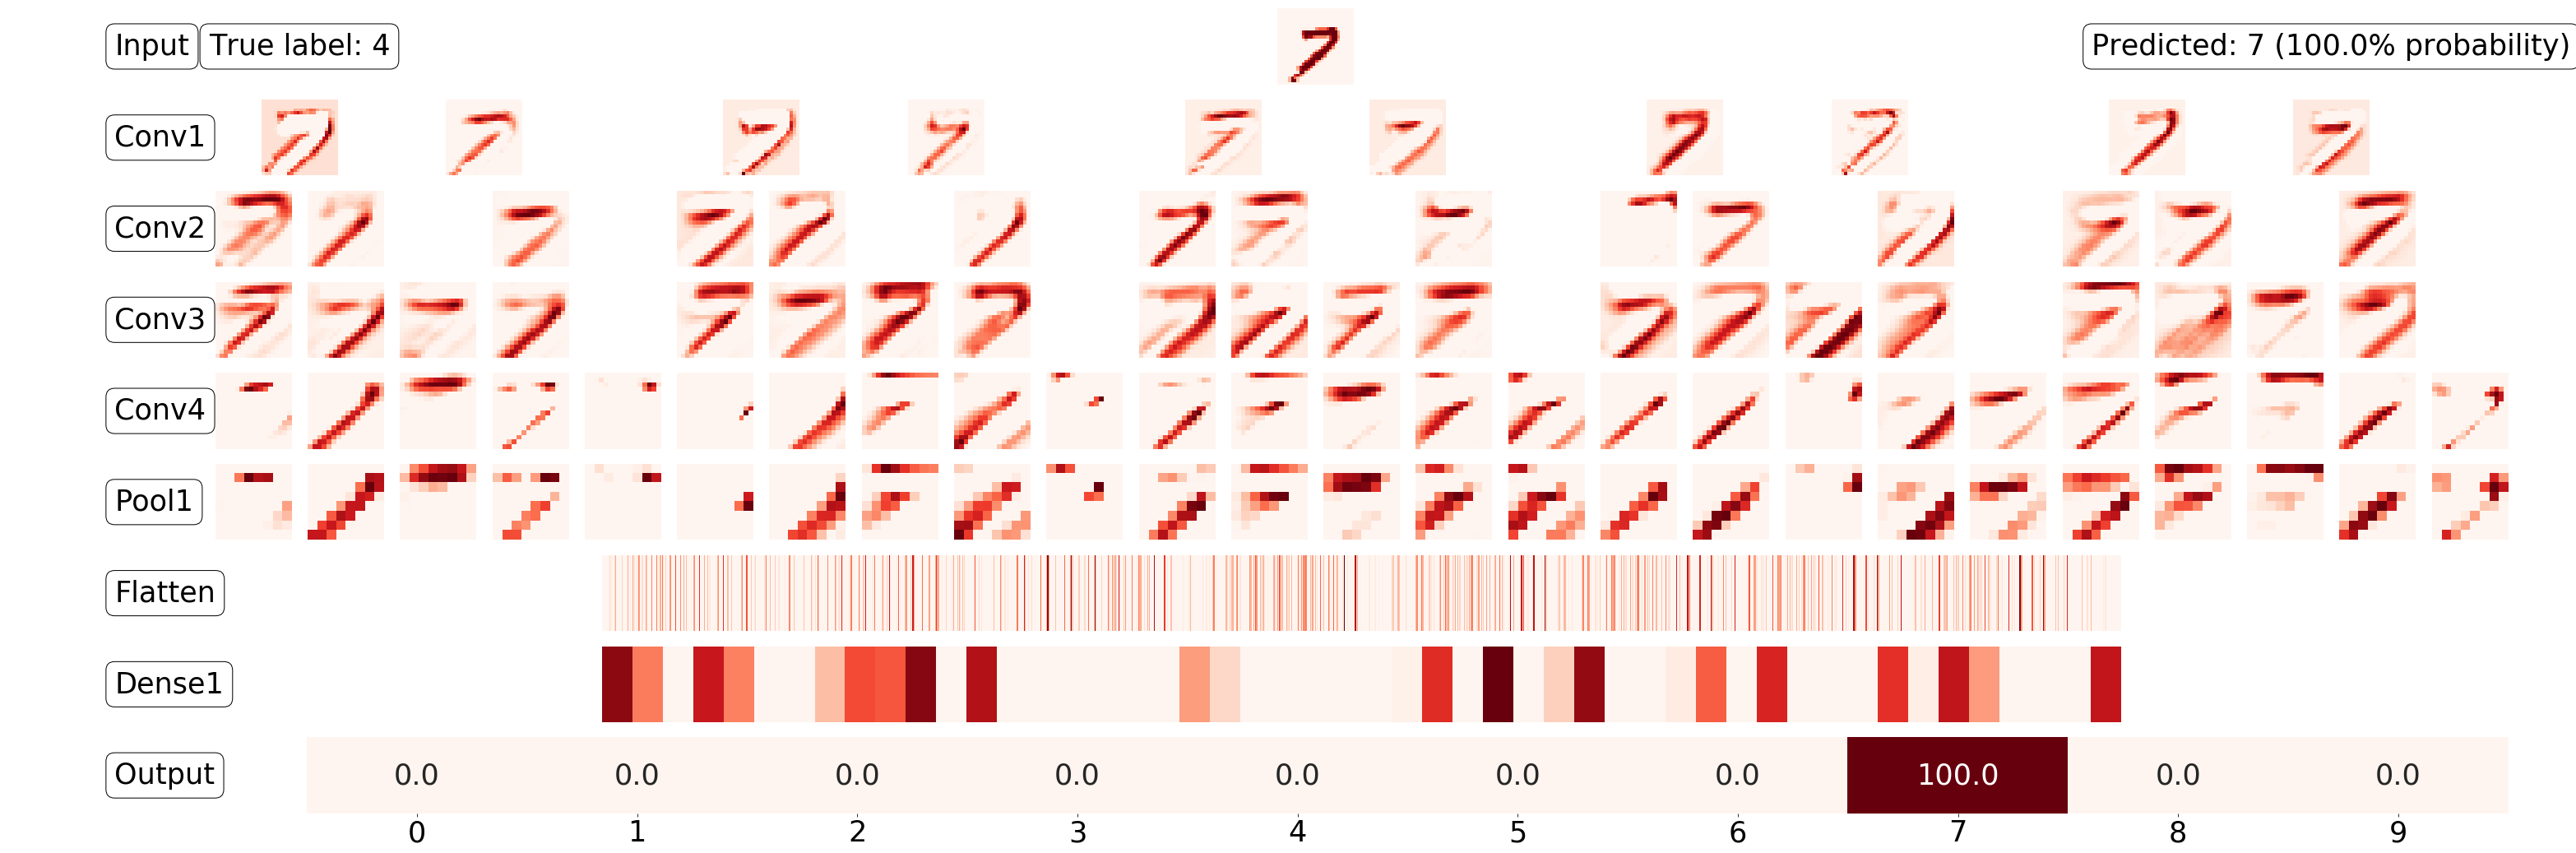

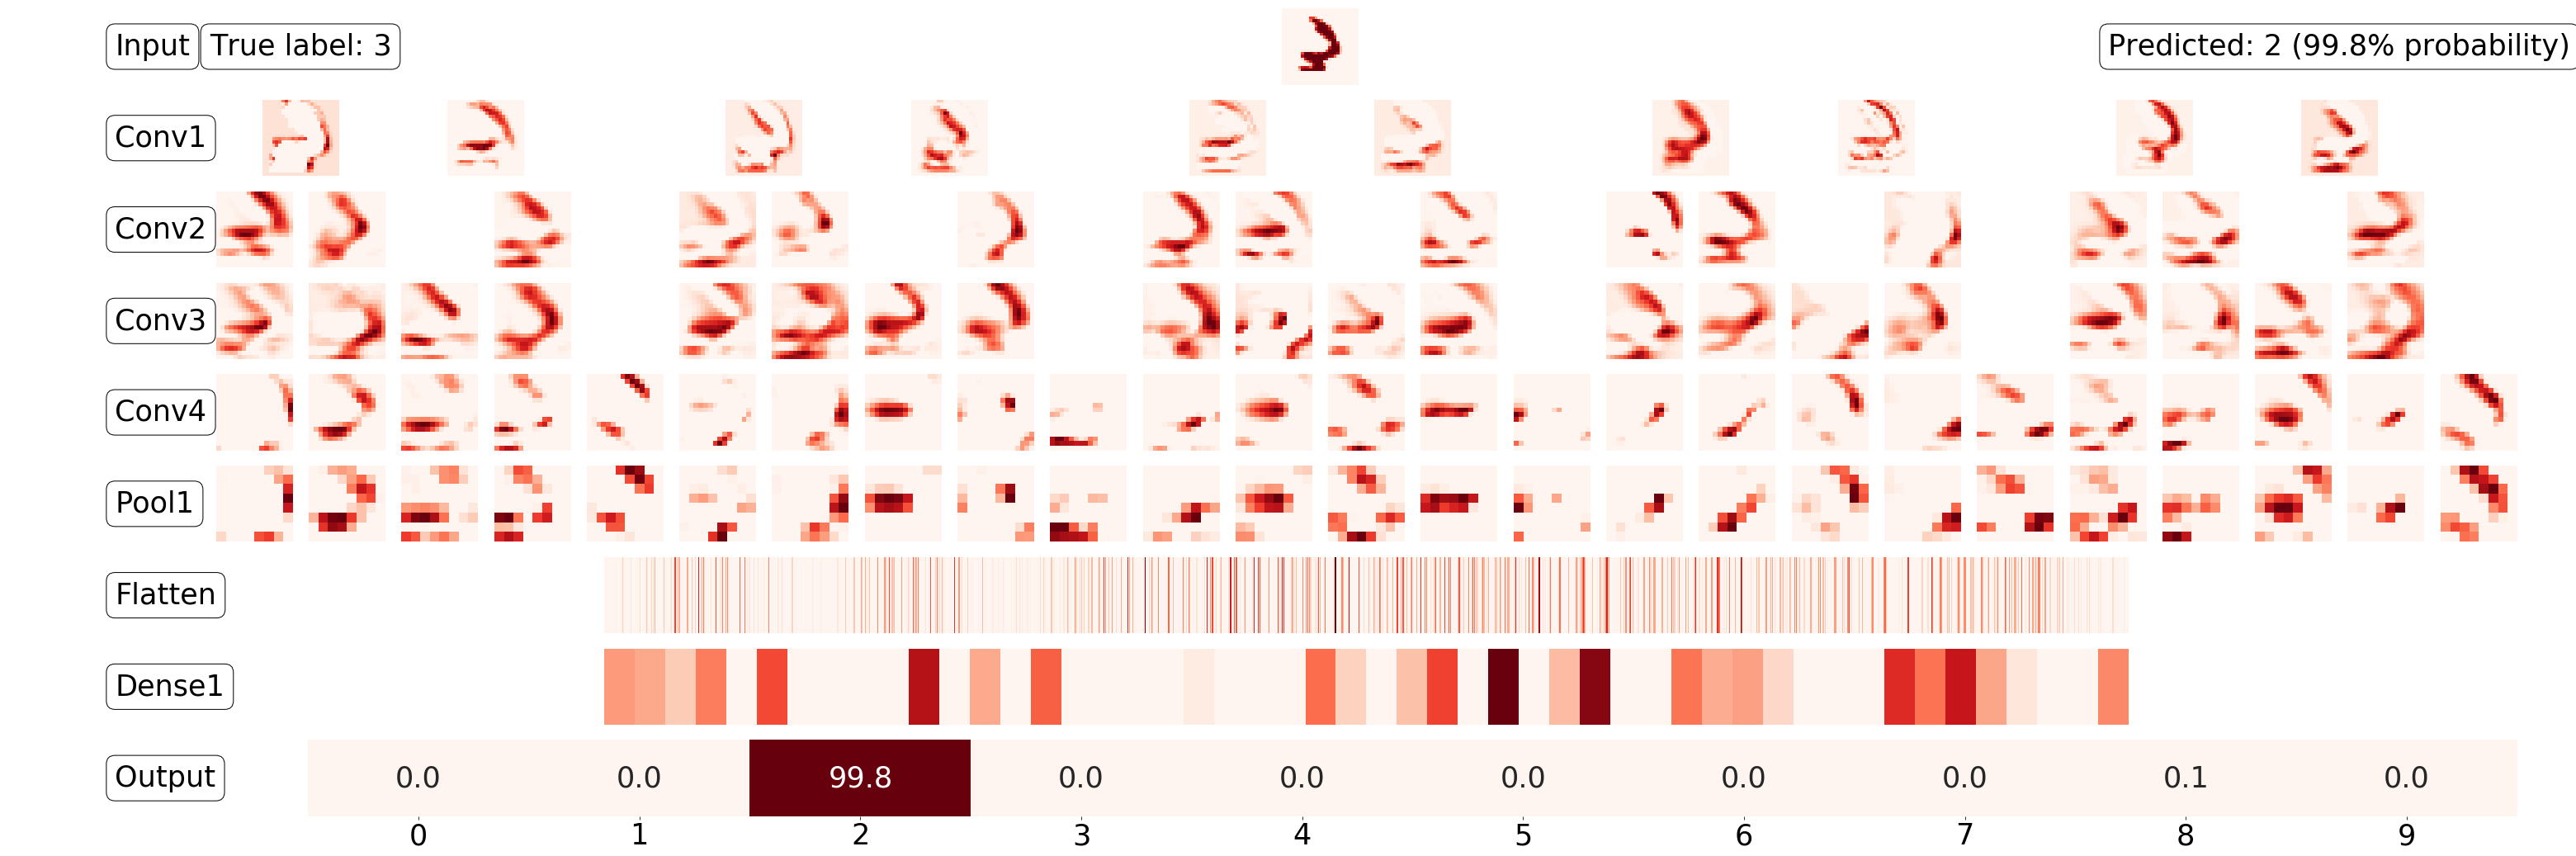

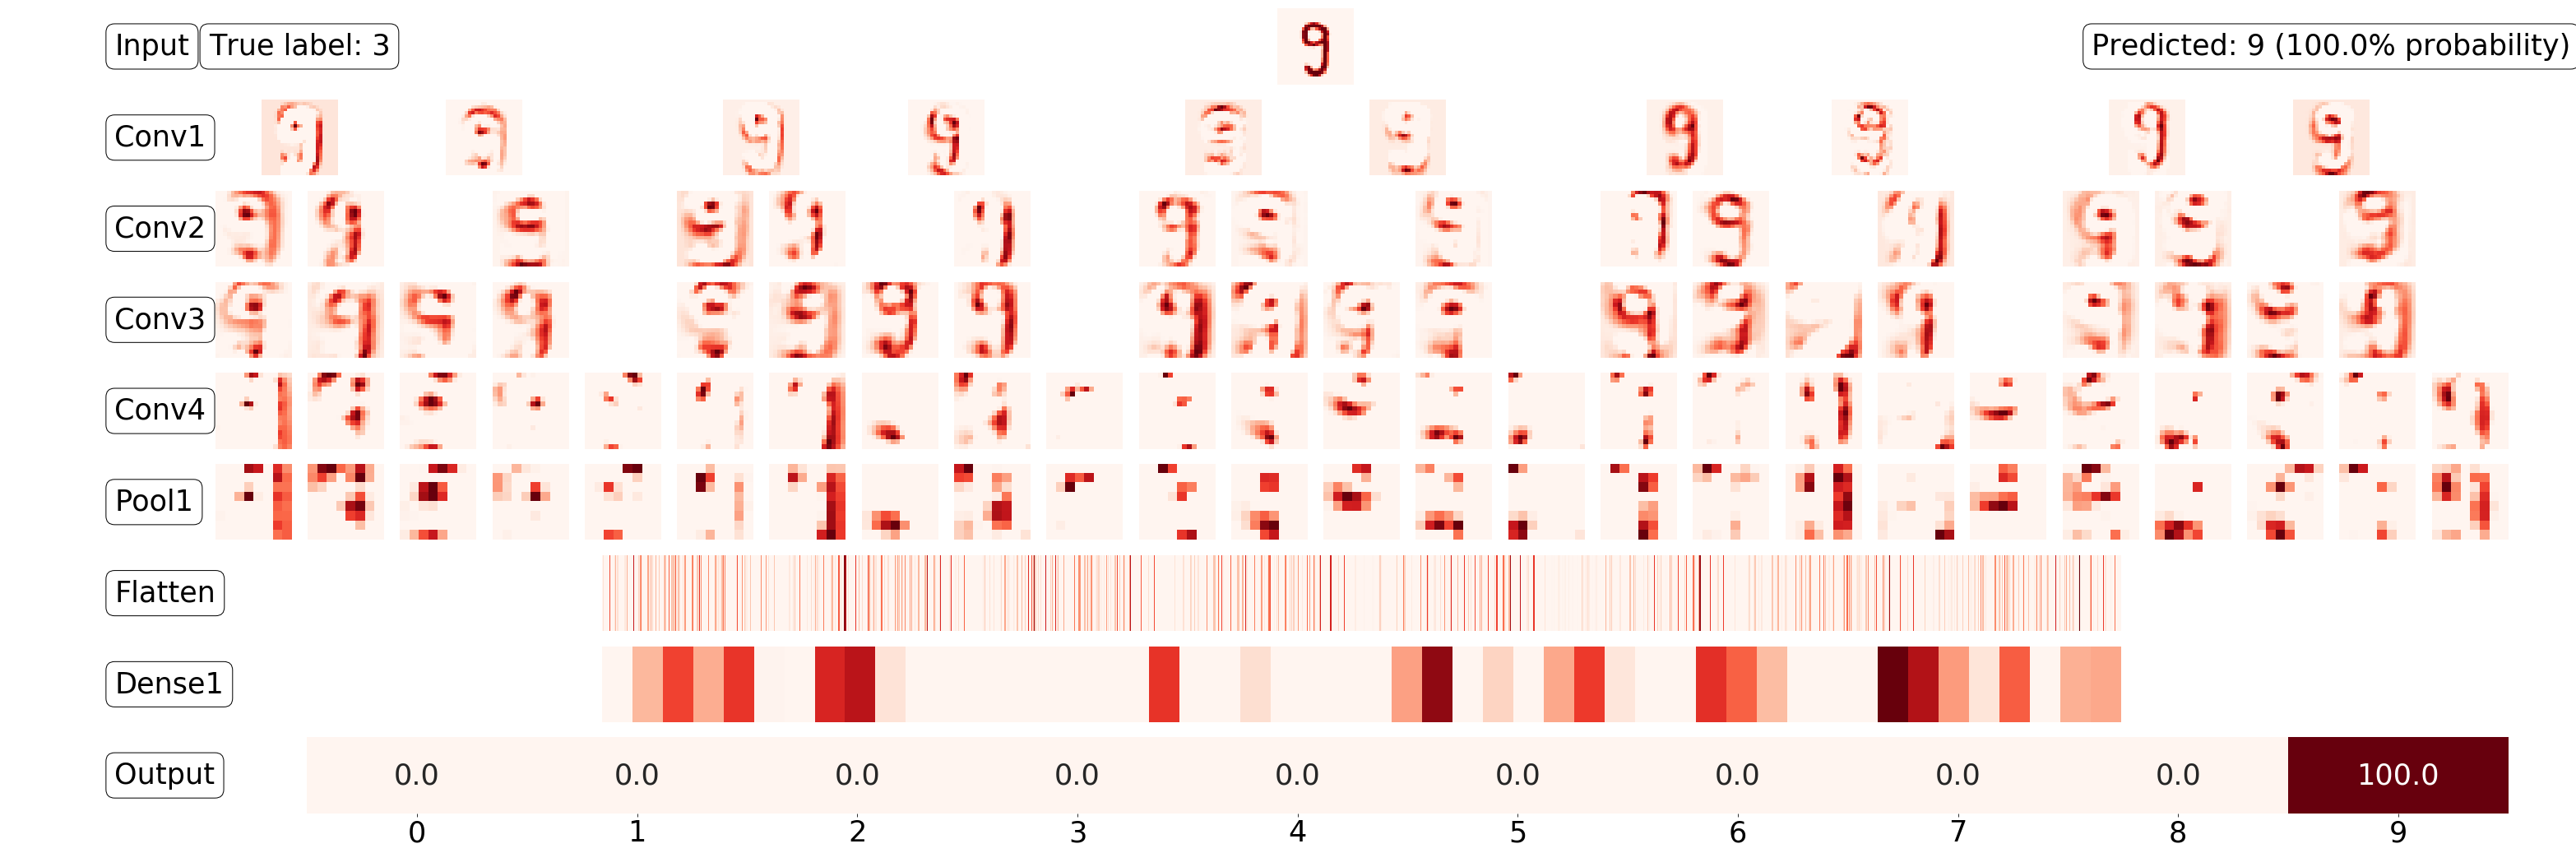

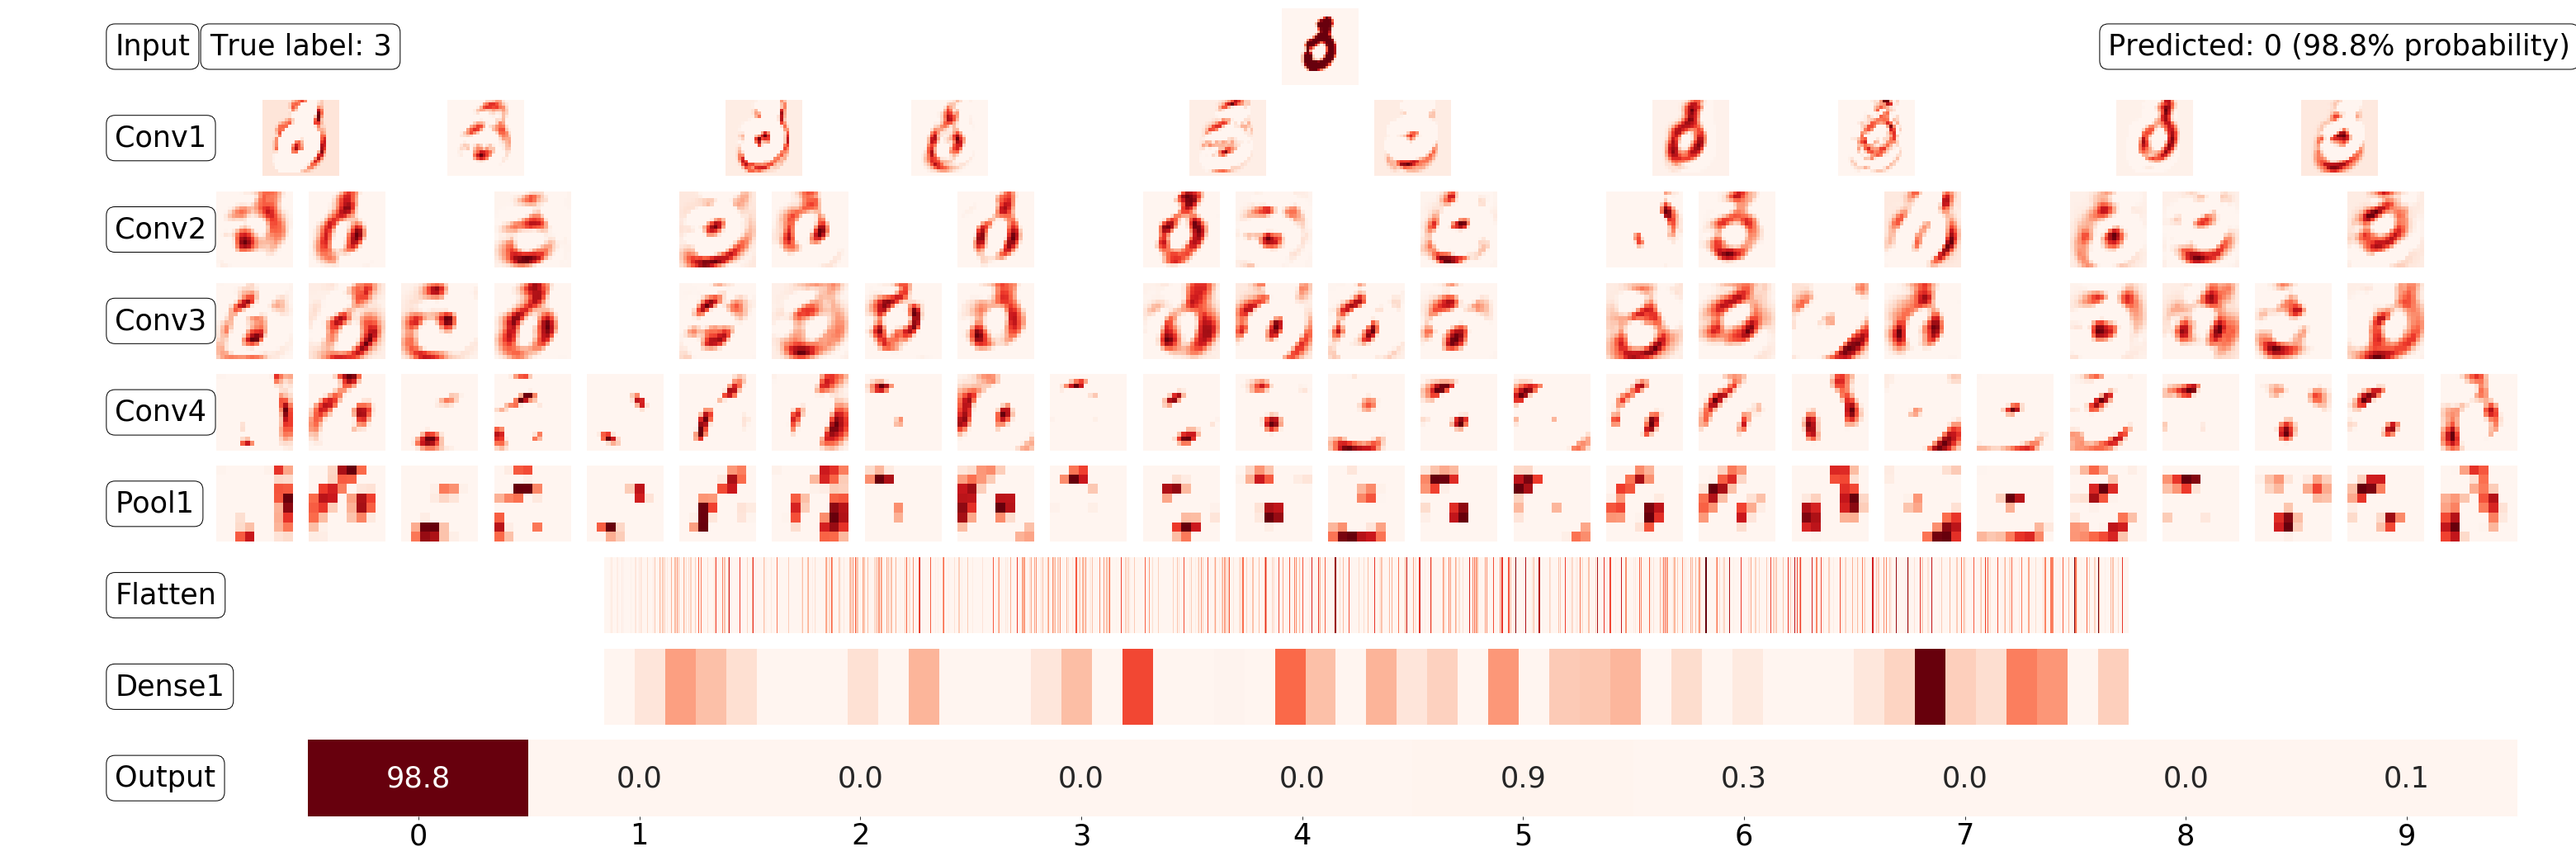

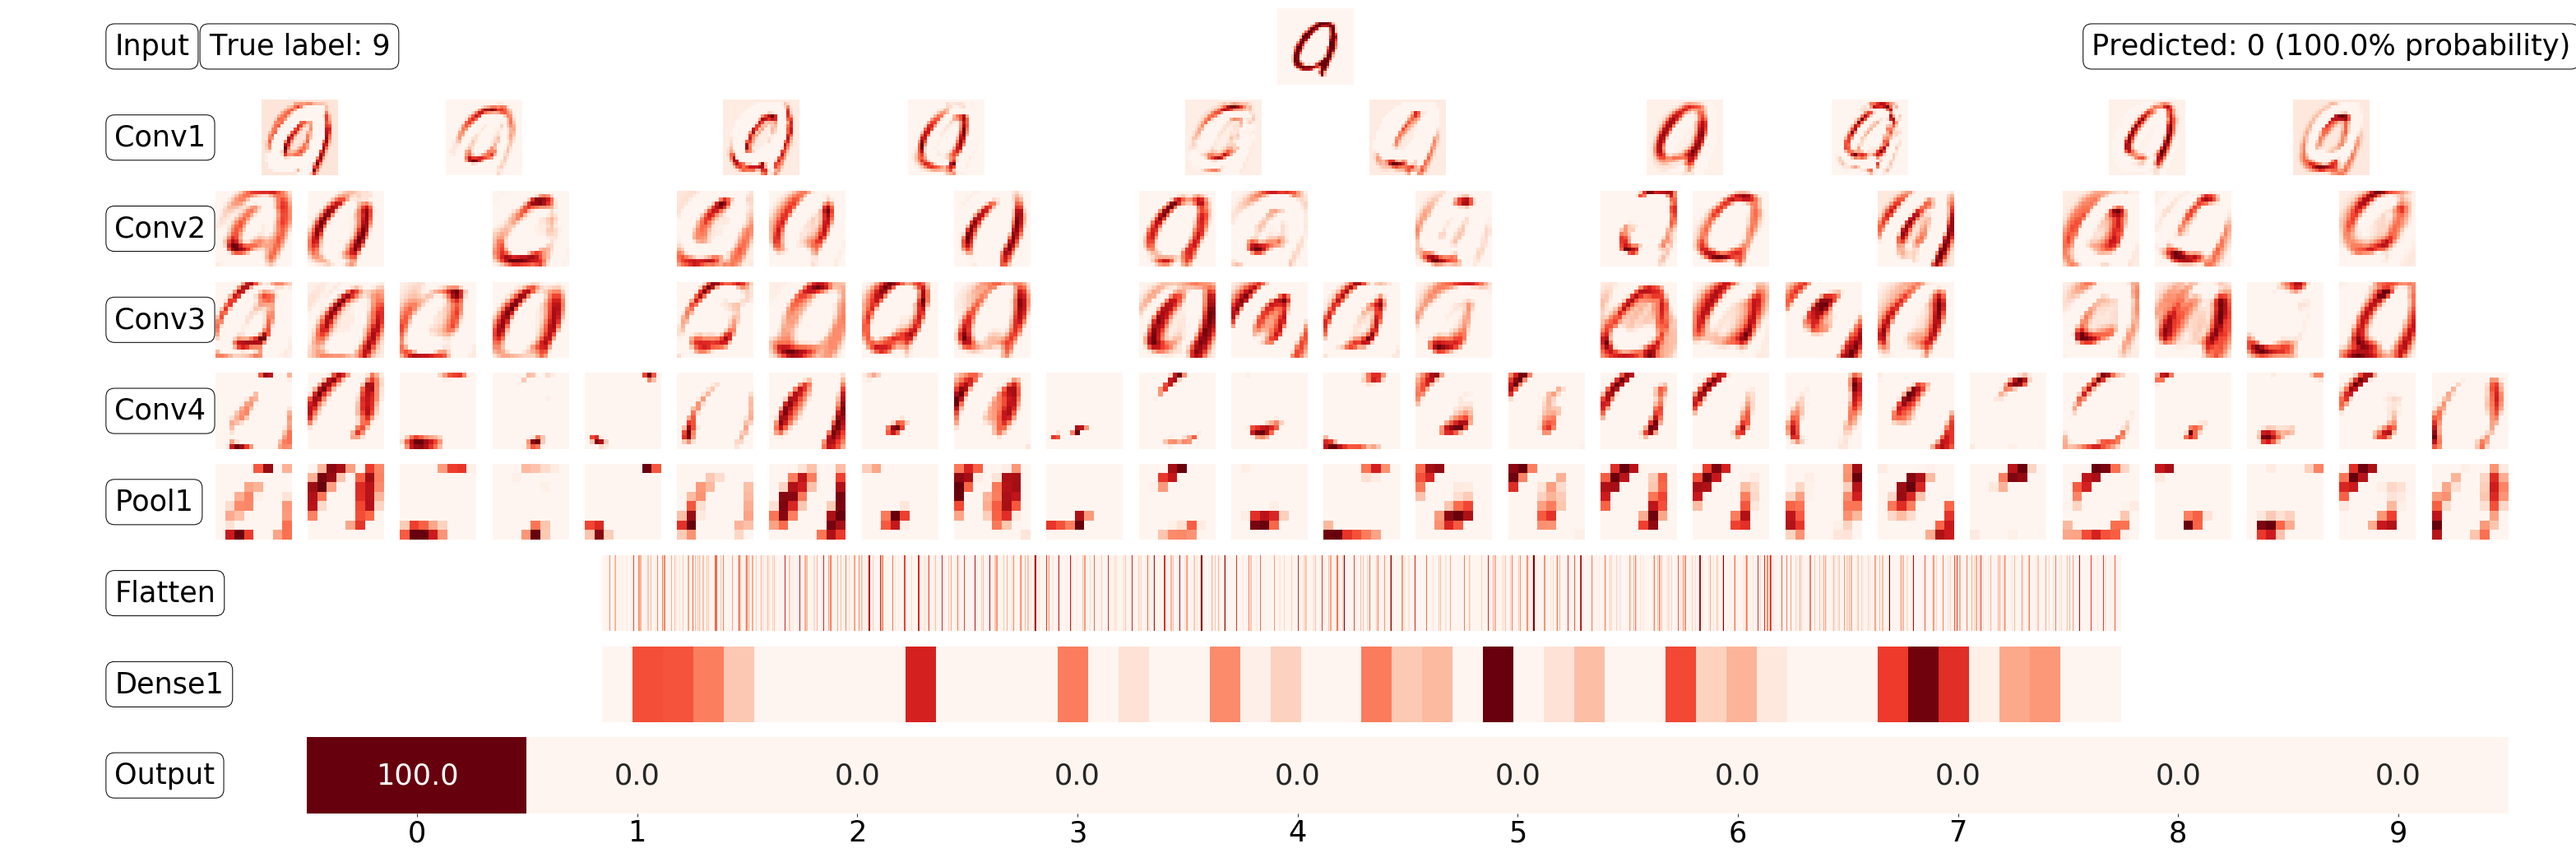

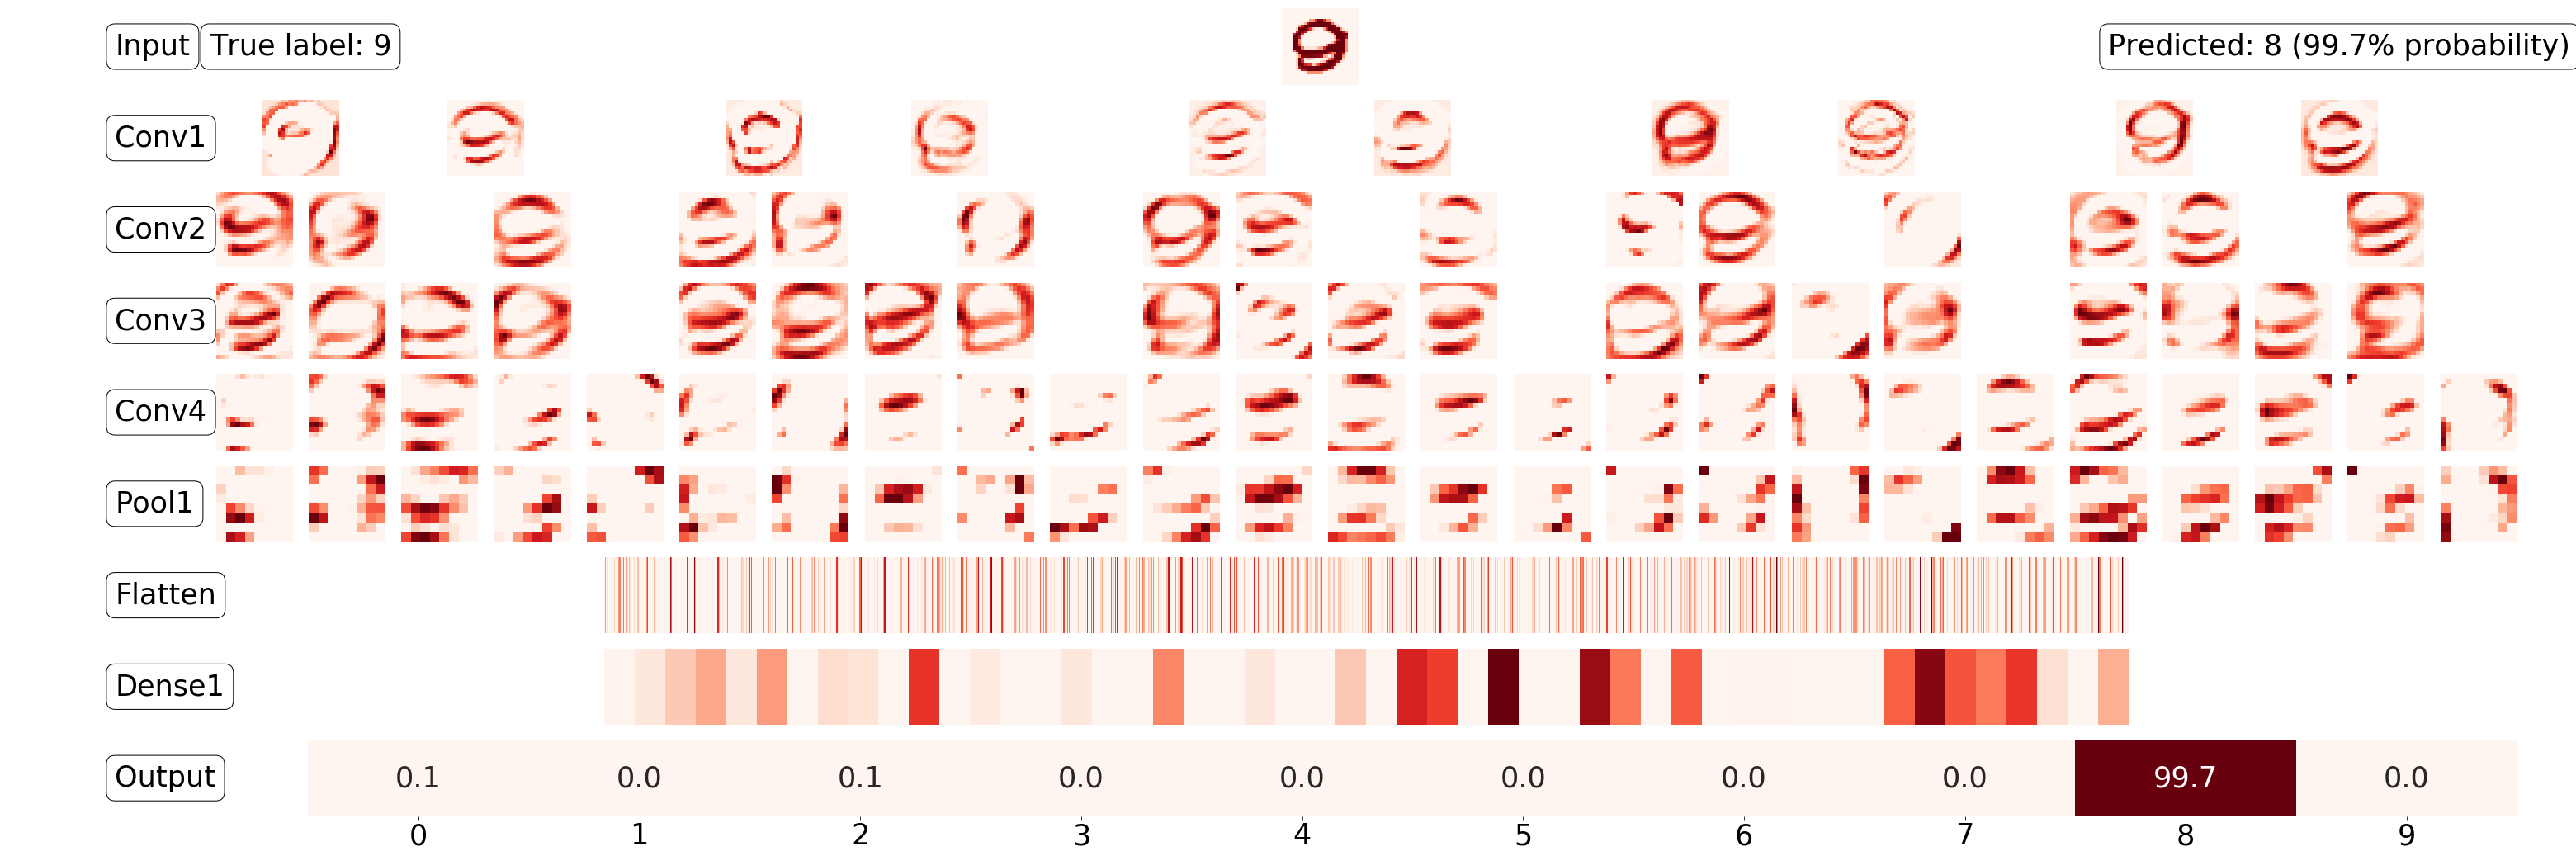

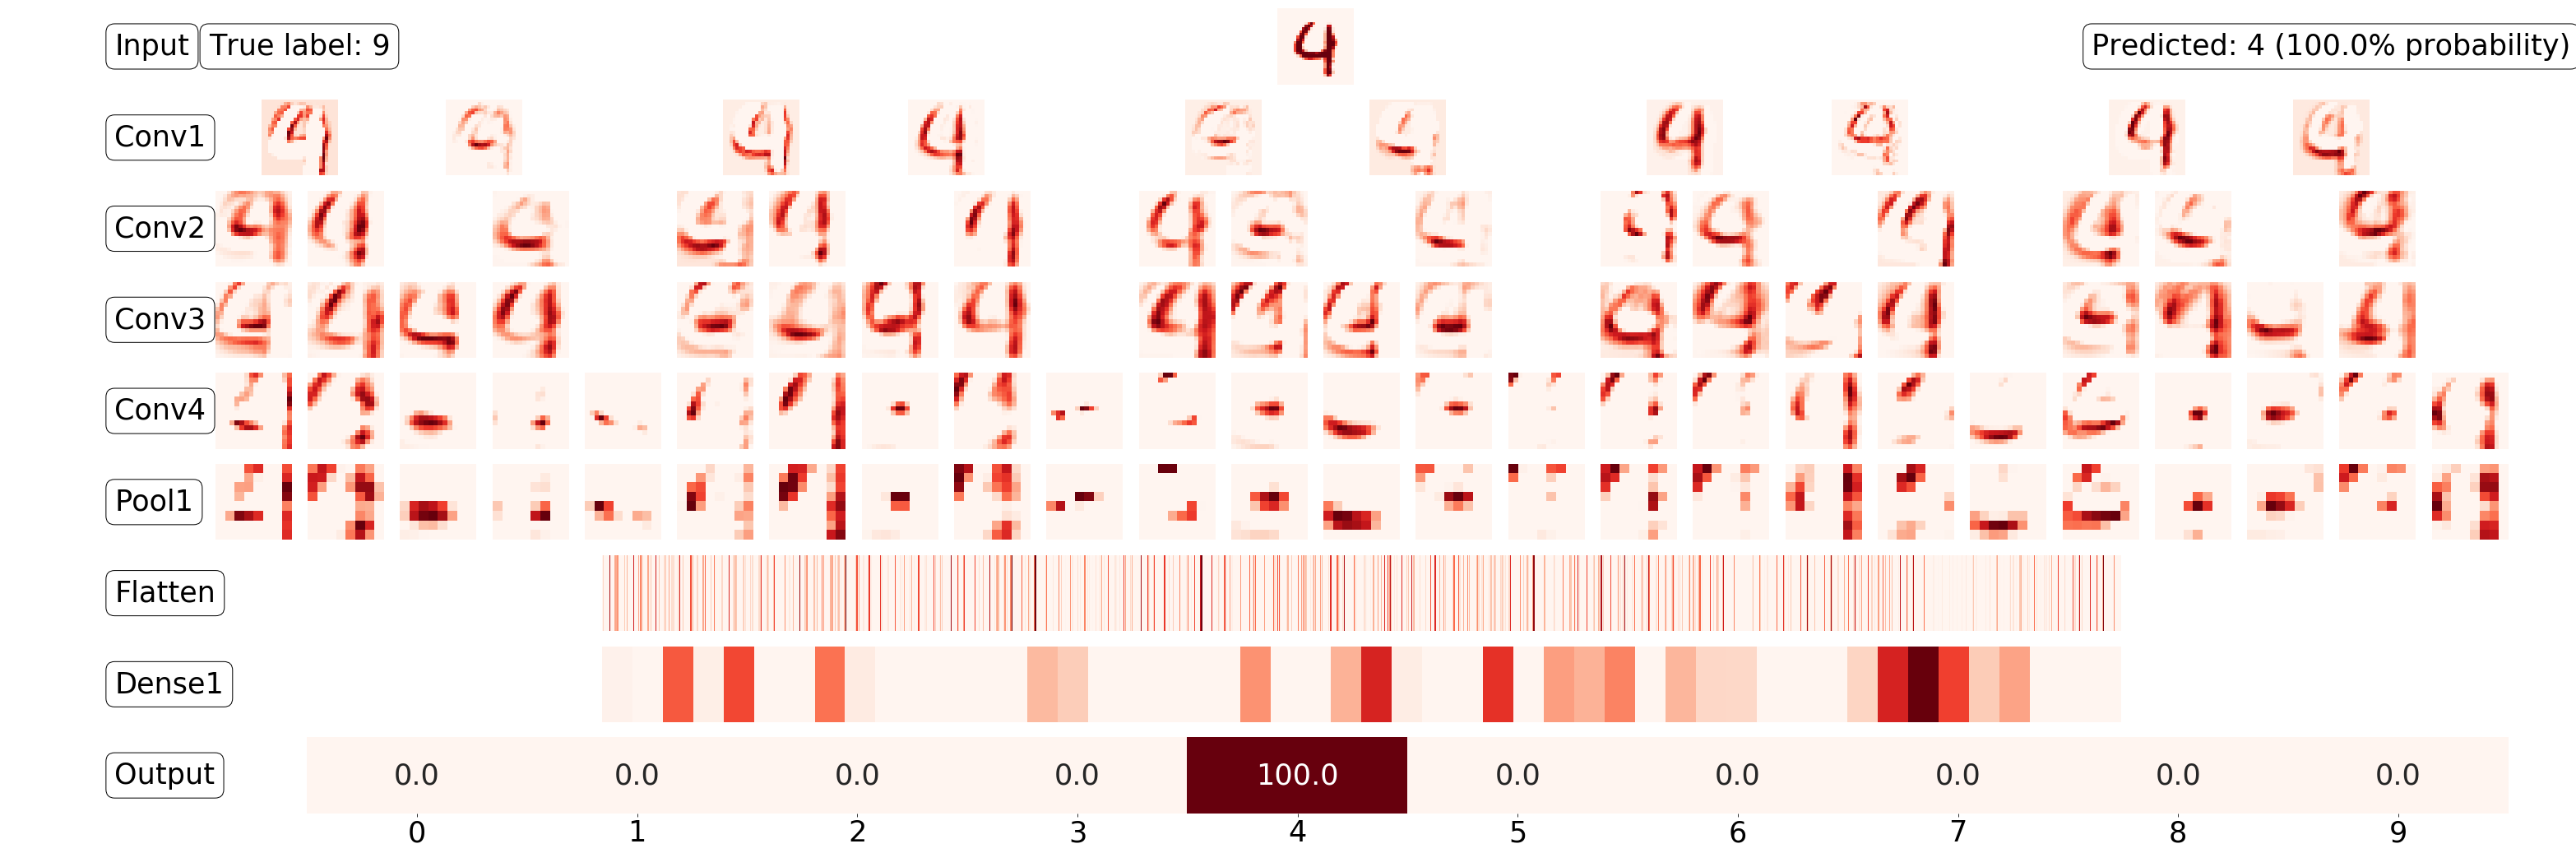

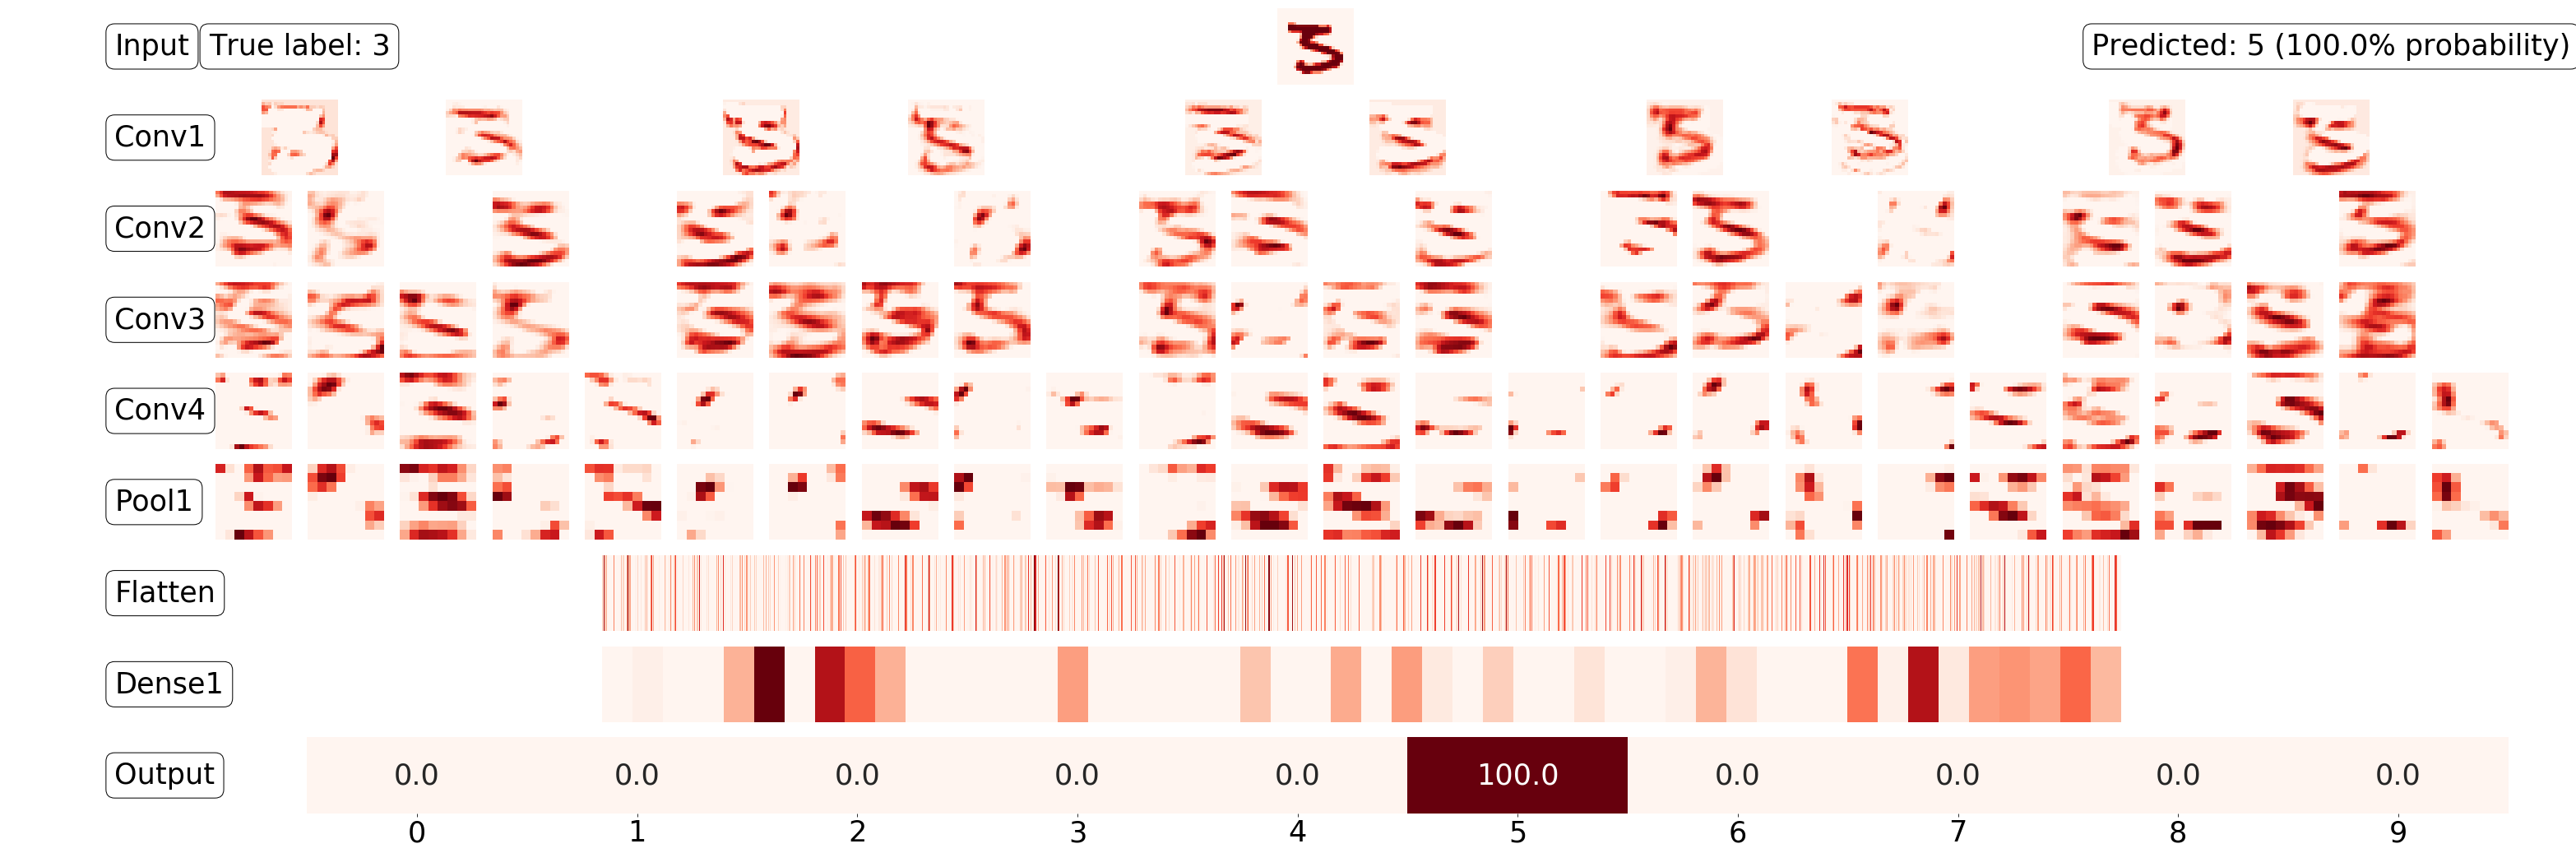

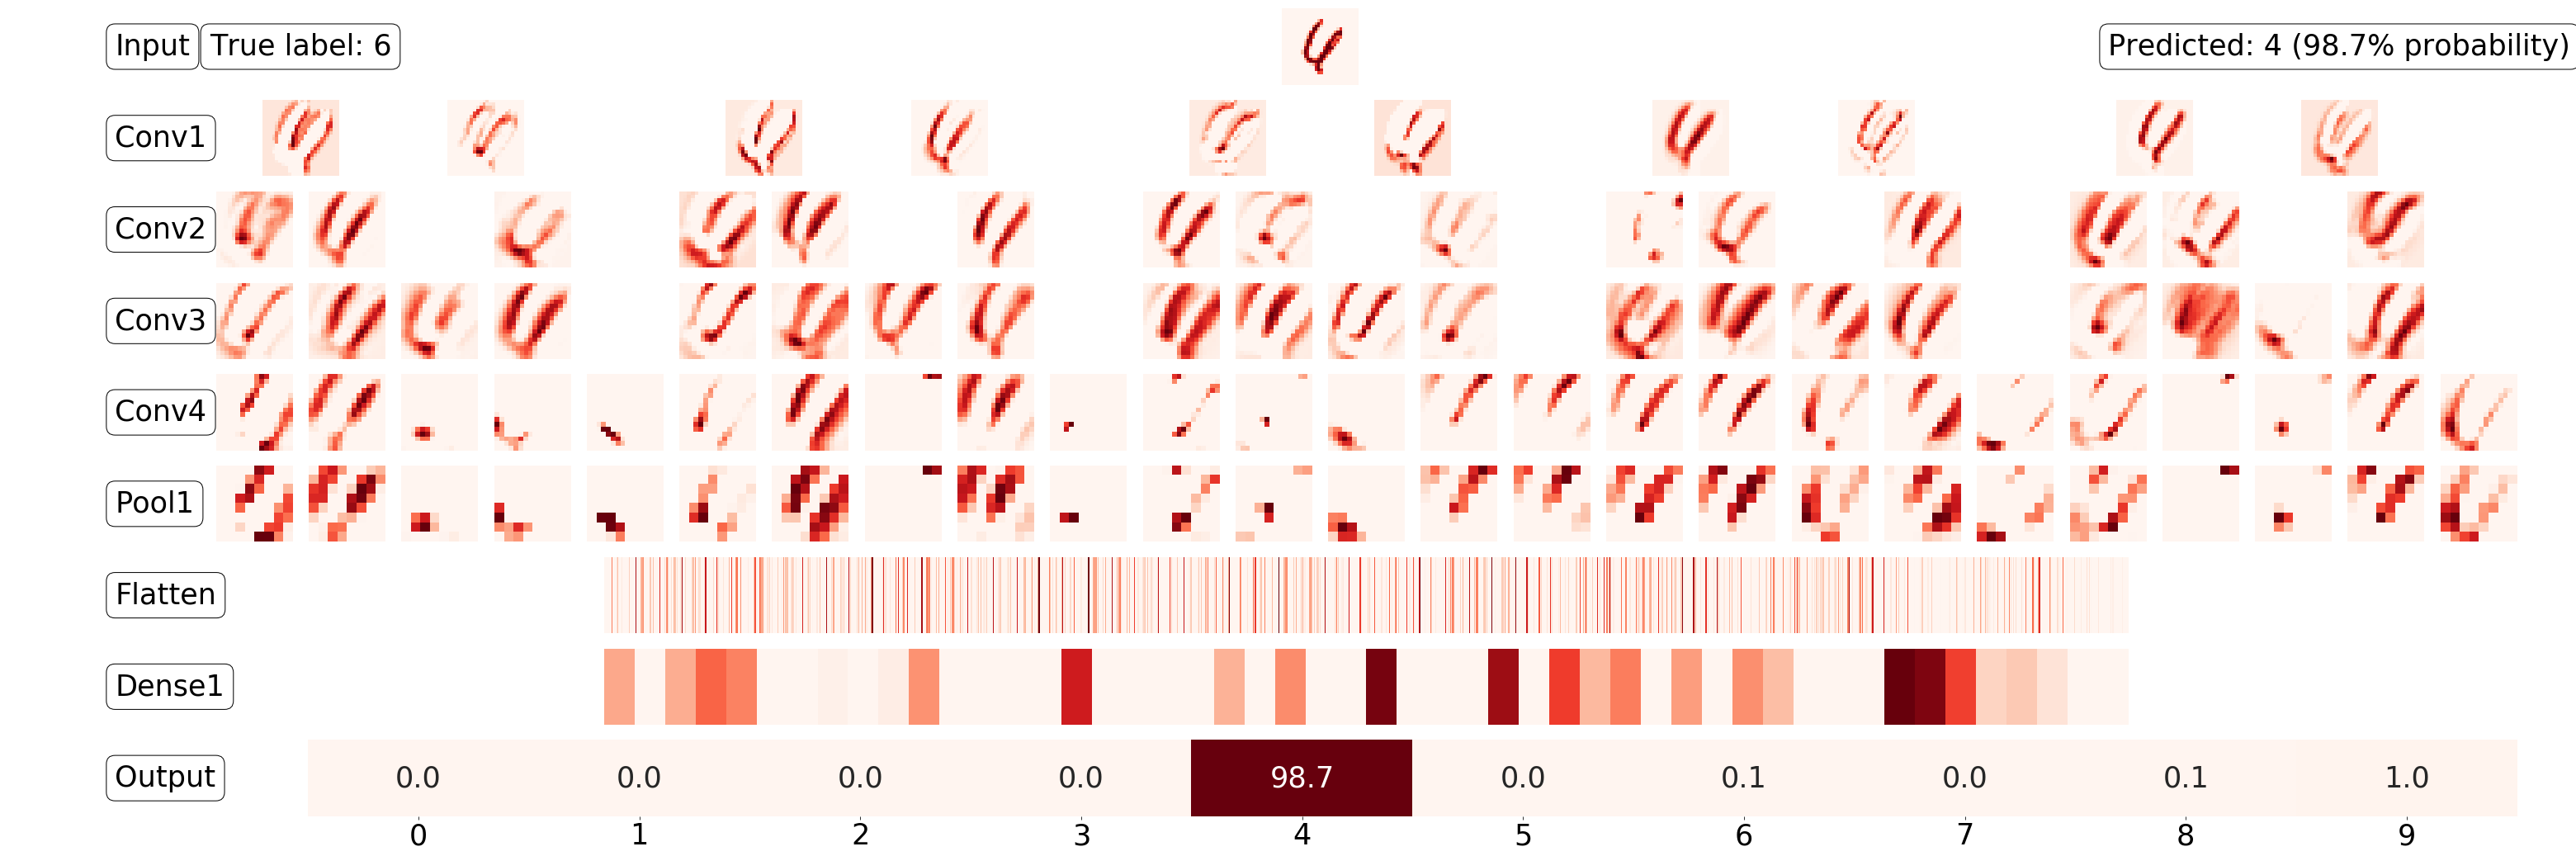

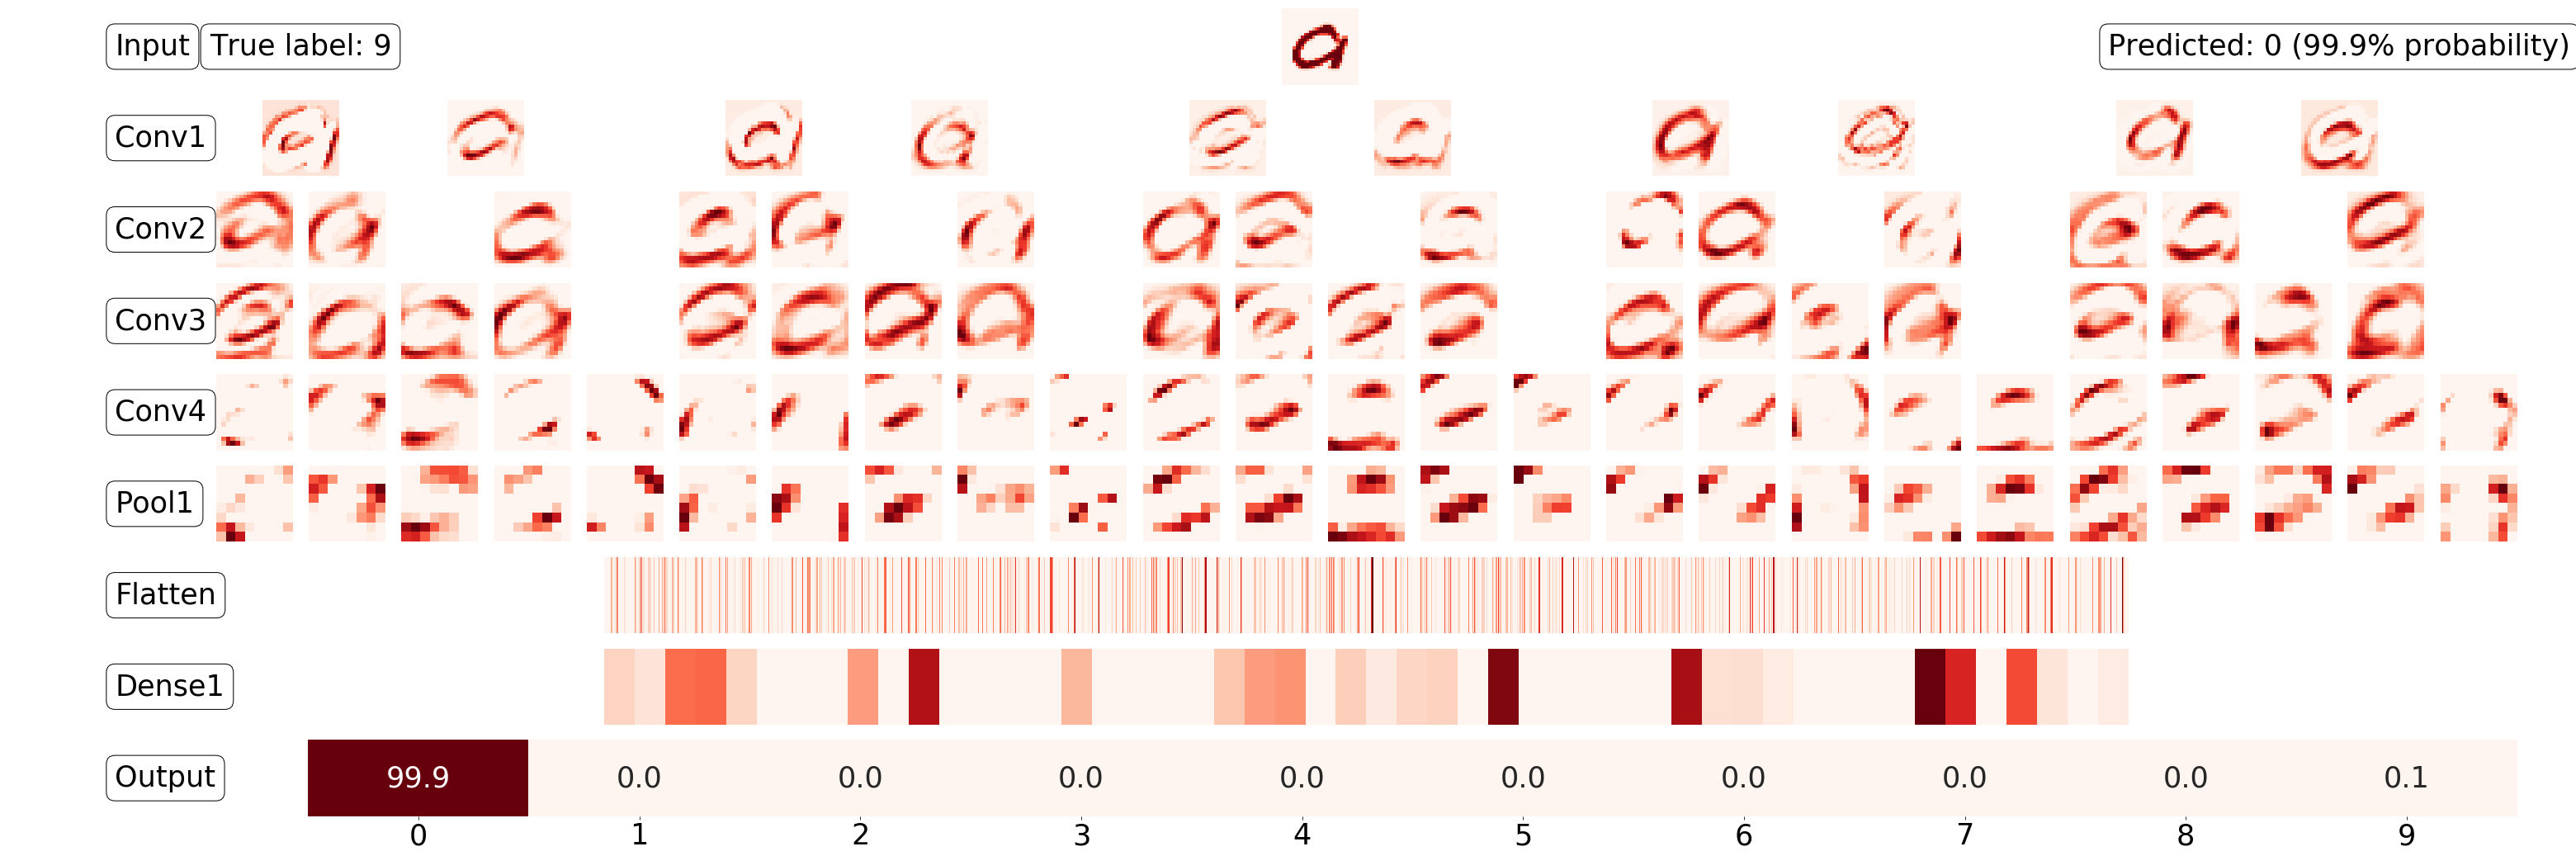

In [59]:
# 10 worst predictions - smallest probability of correct label
wrong_pred = true_prob.sort_values().index[:10]

for img_id in wrong_pred:
    plot_network(img_id)

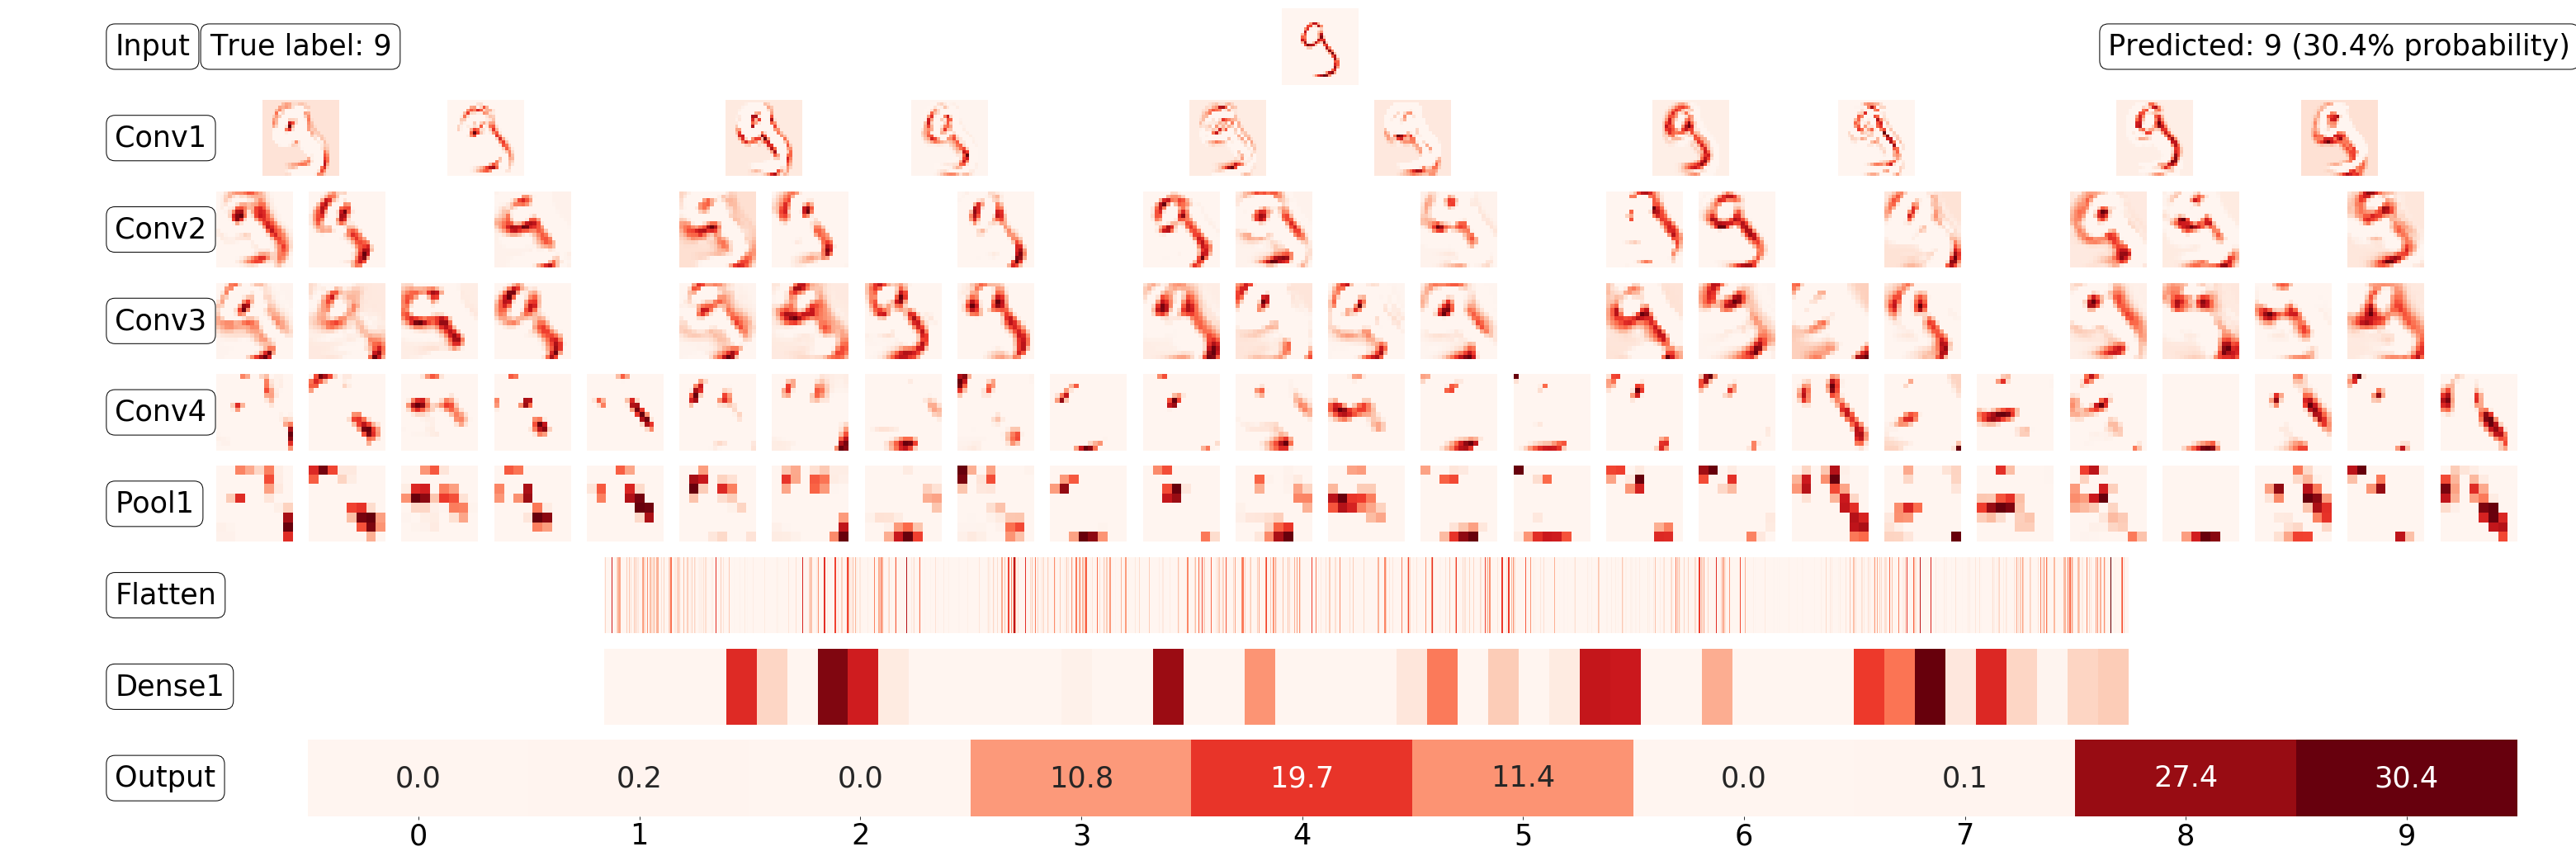

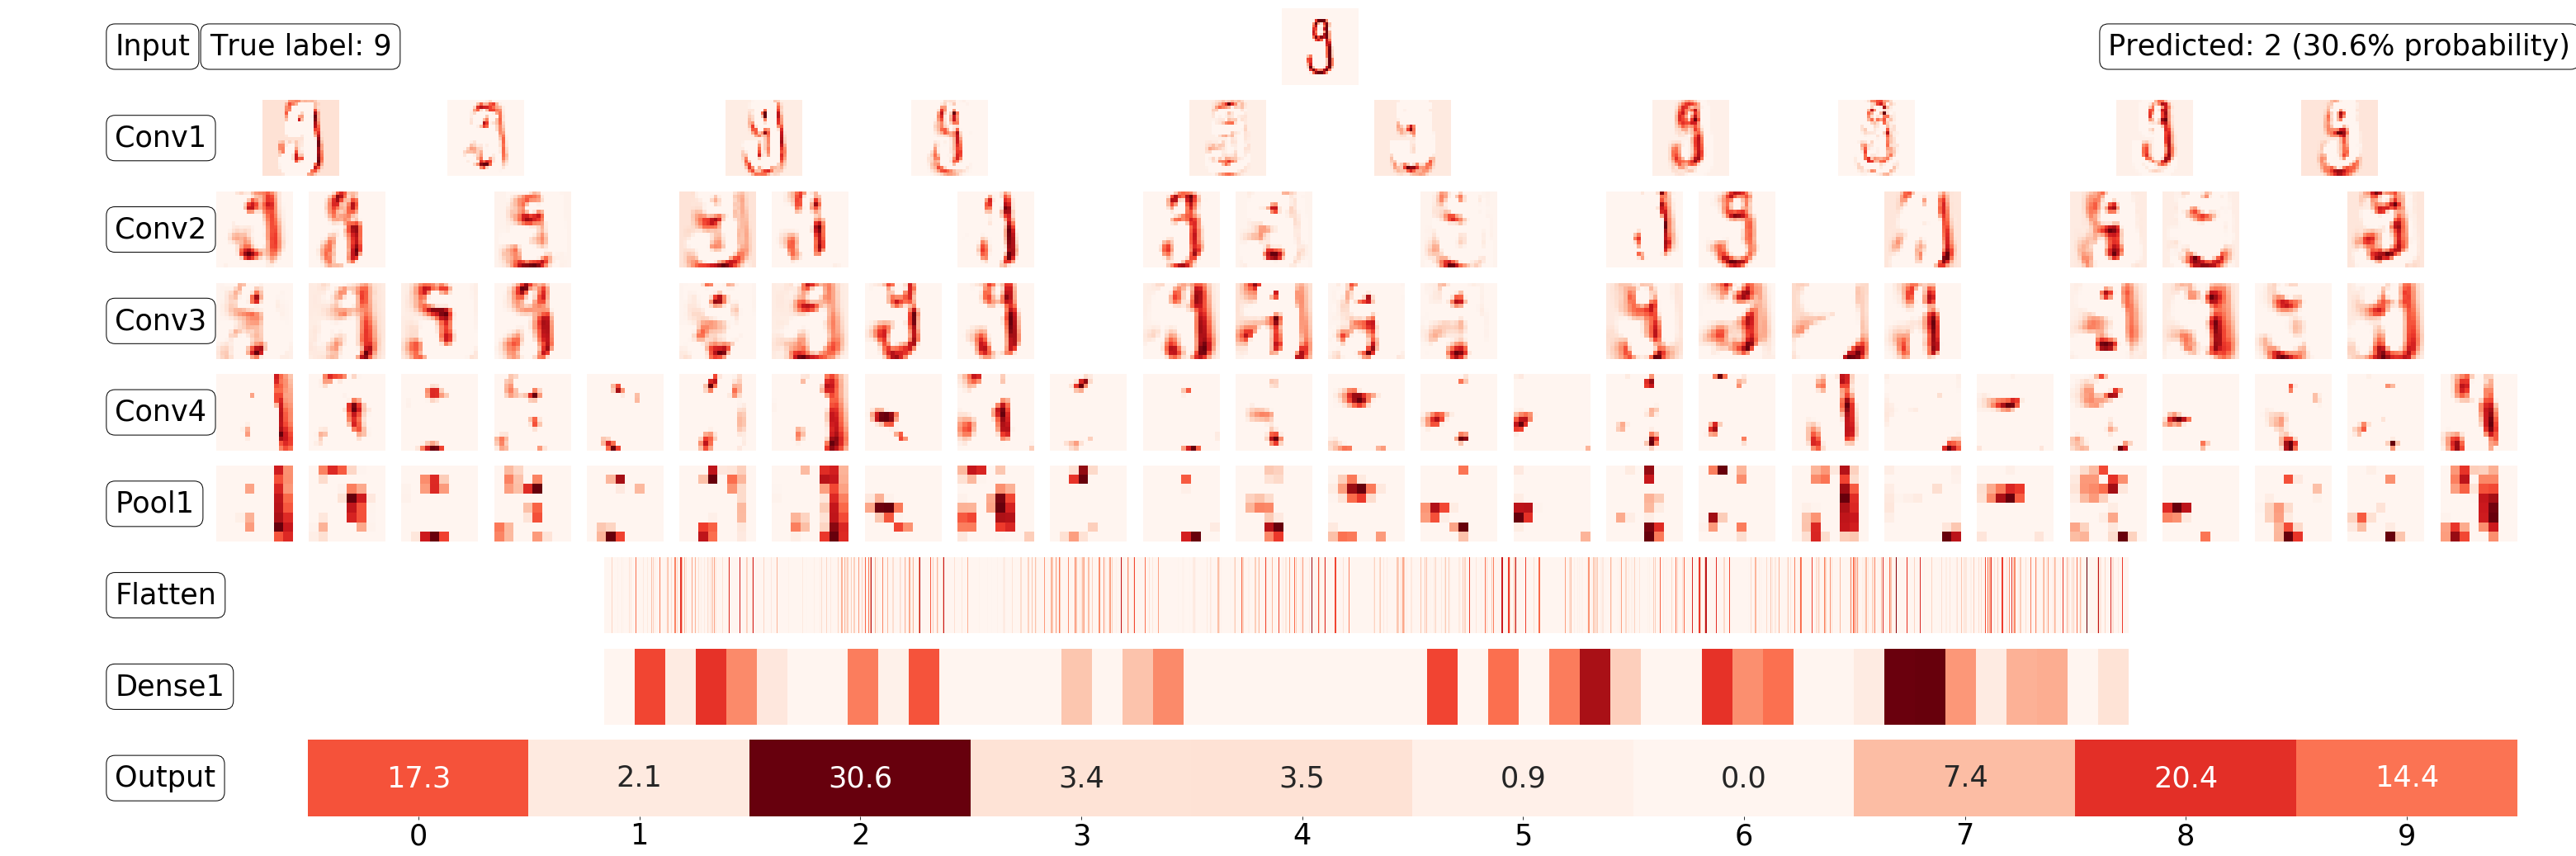

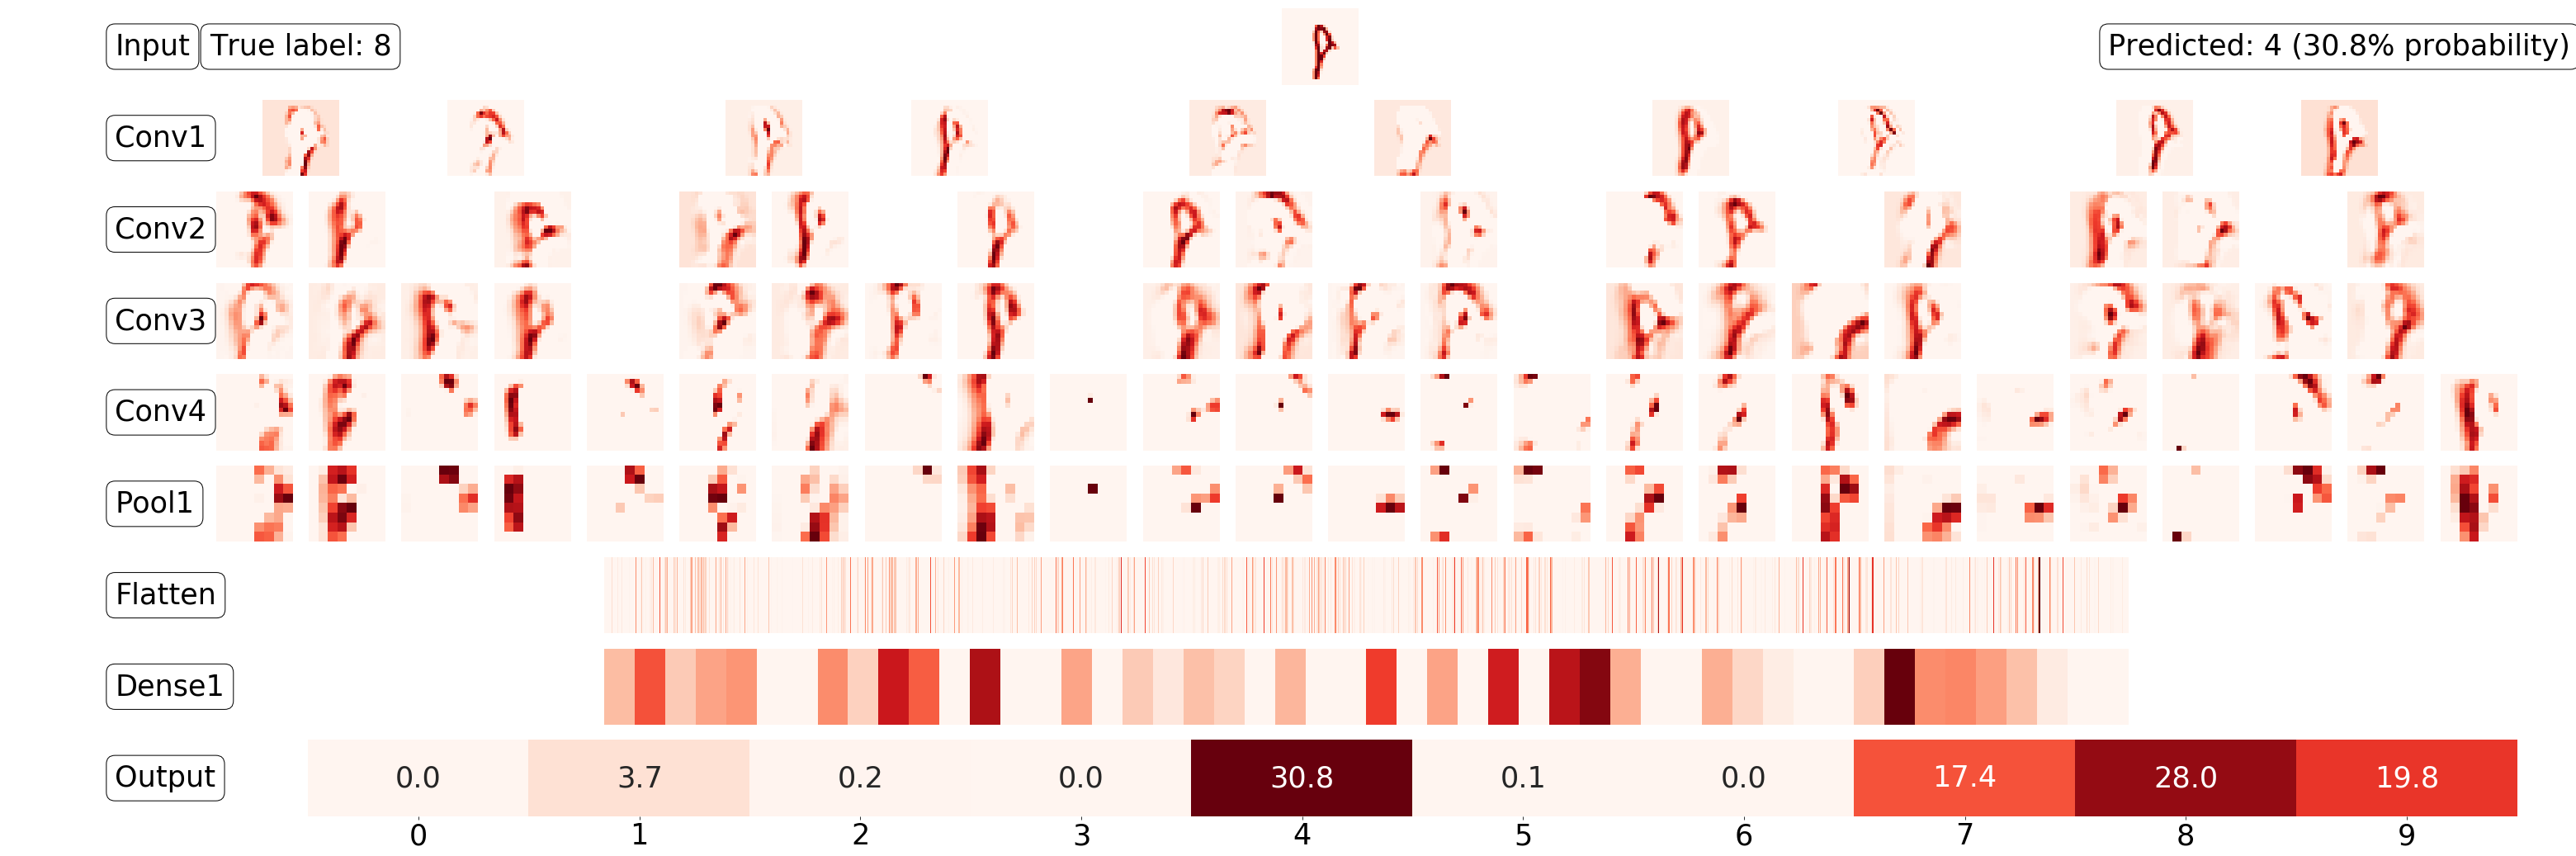

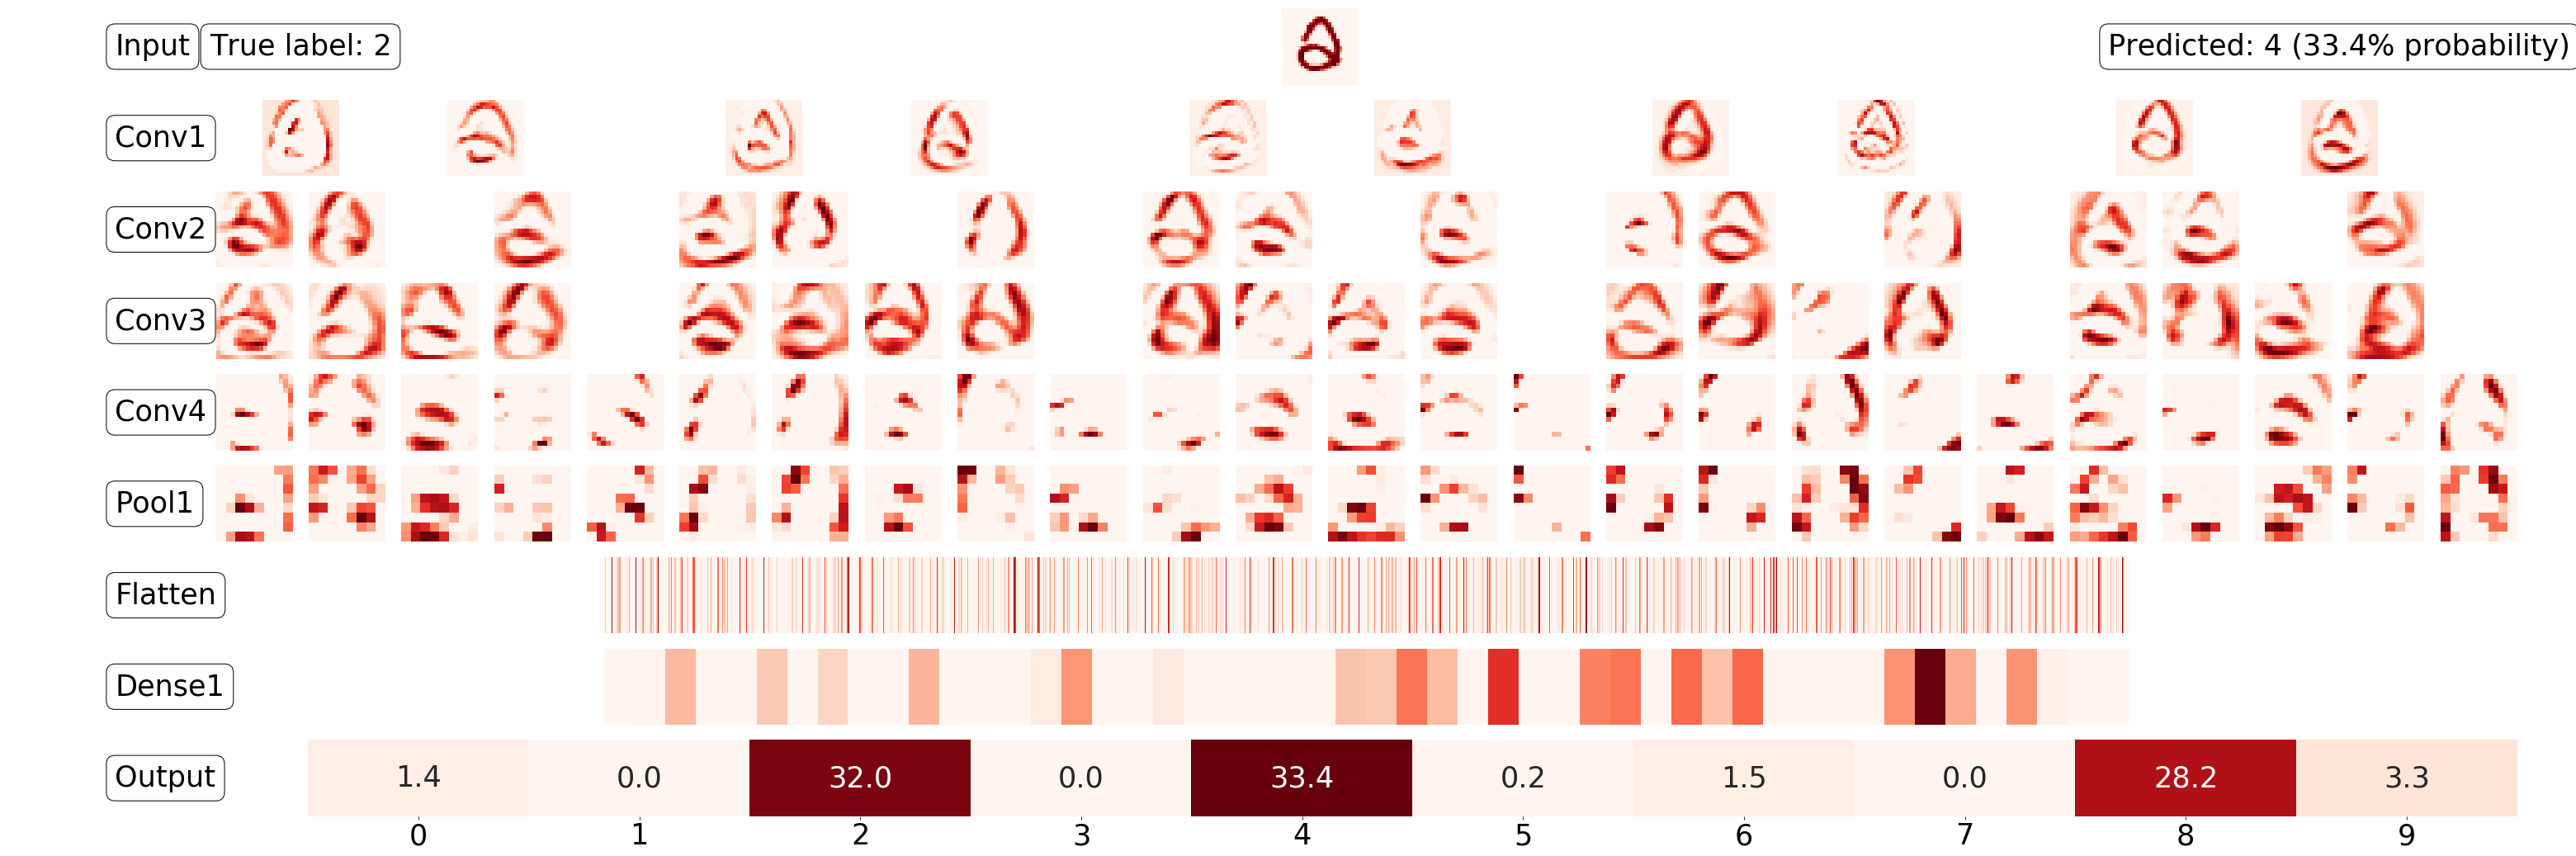

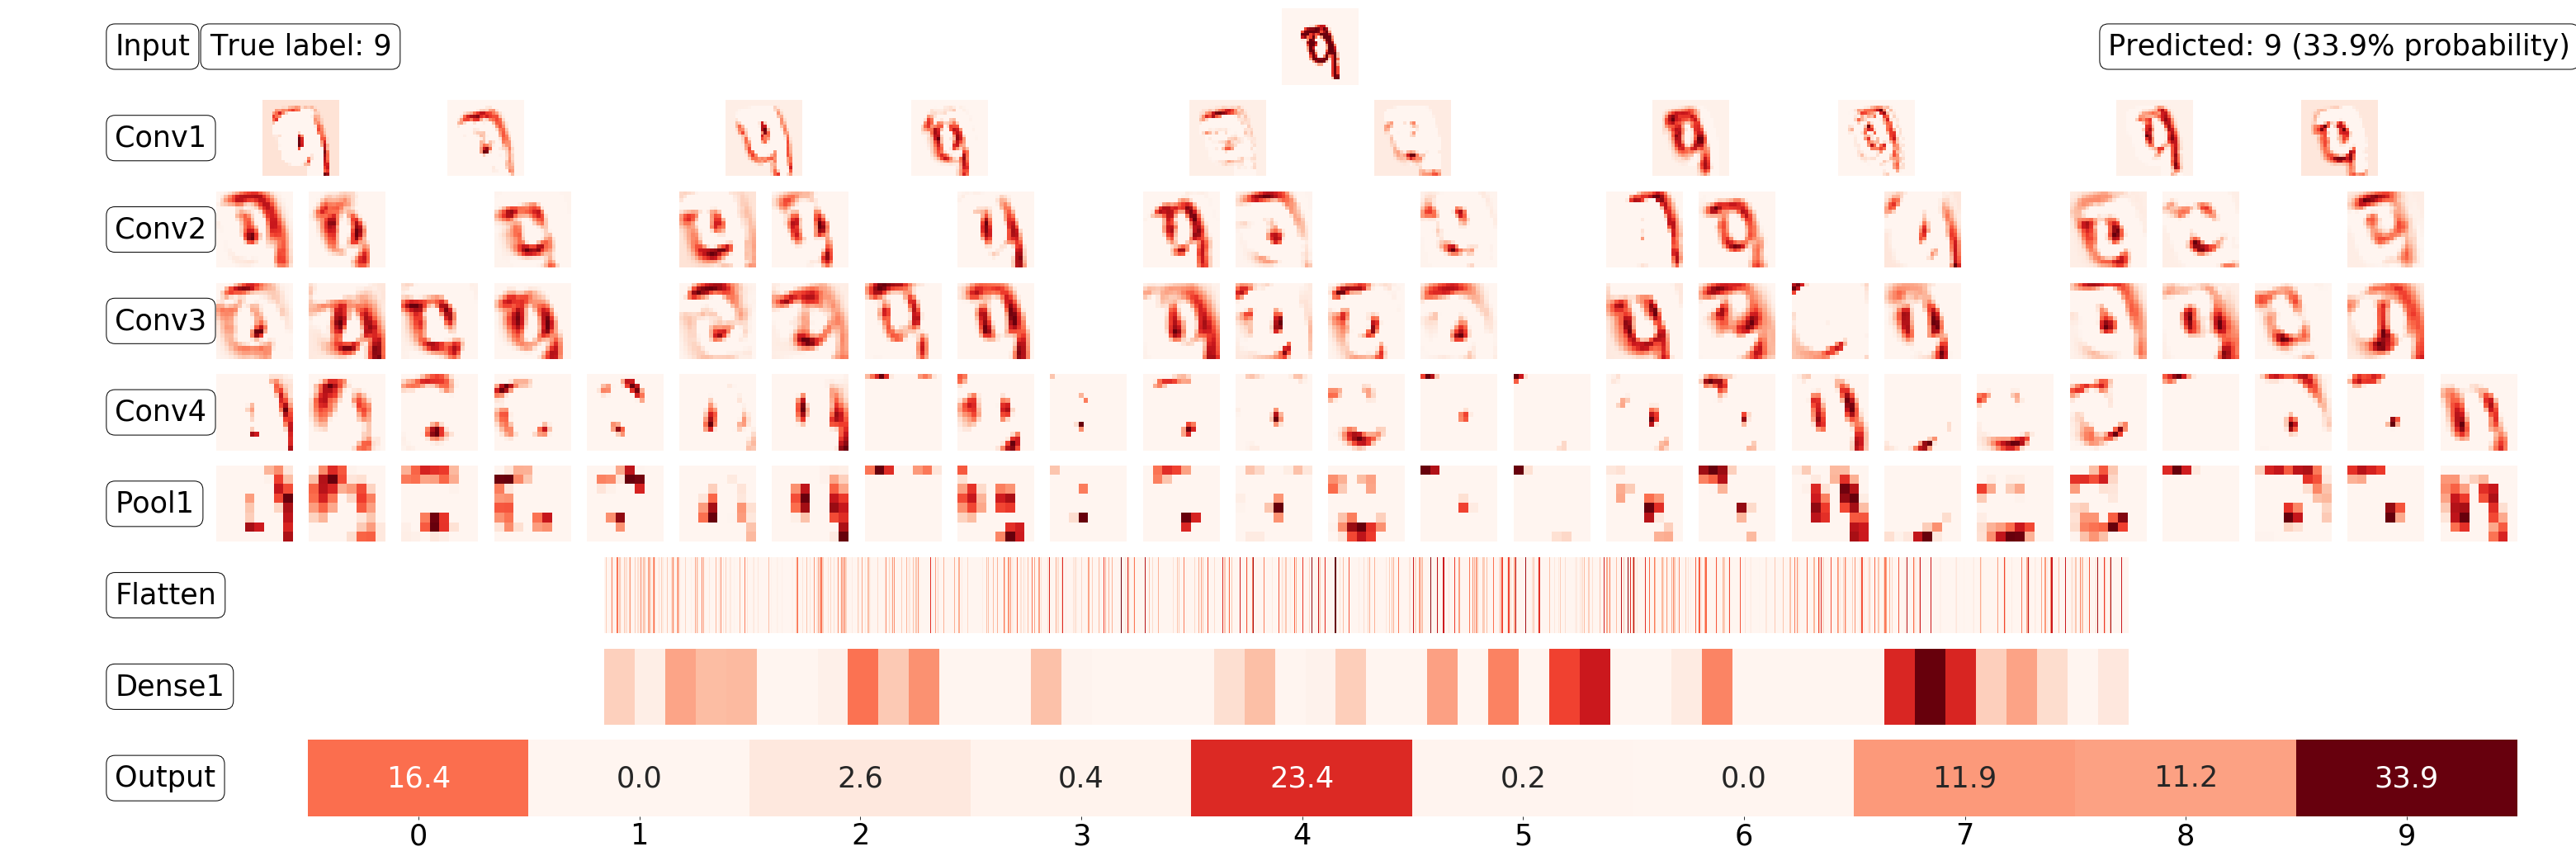

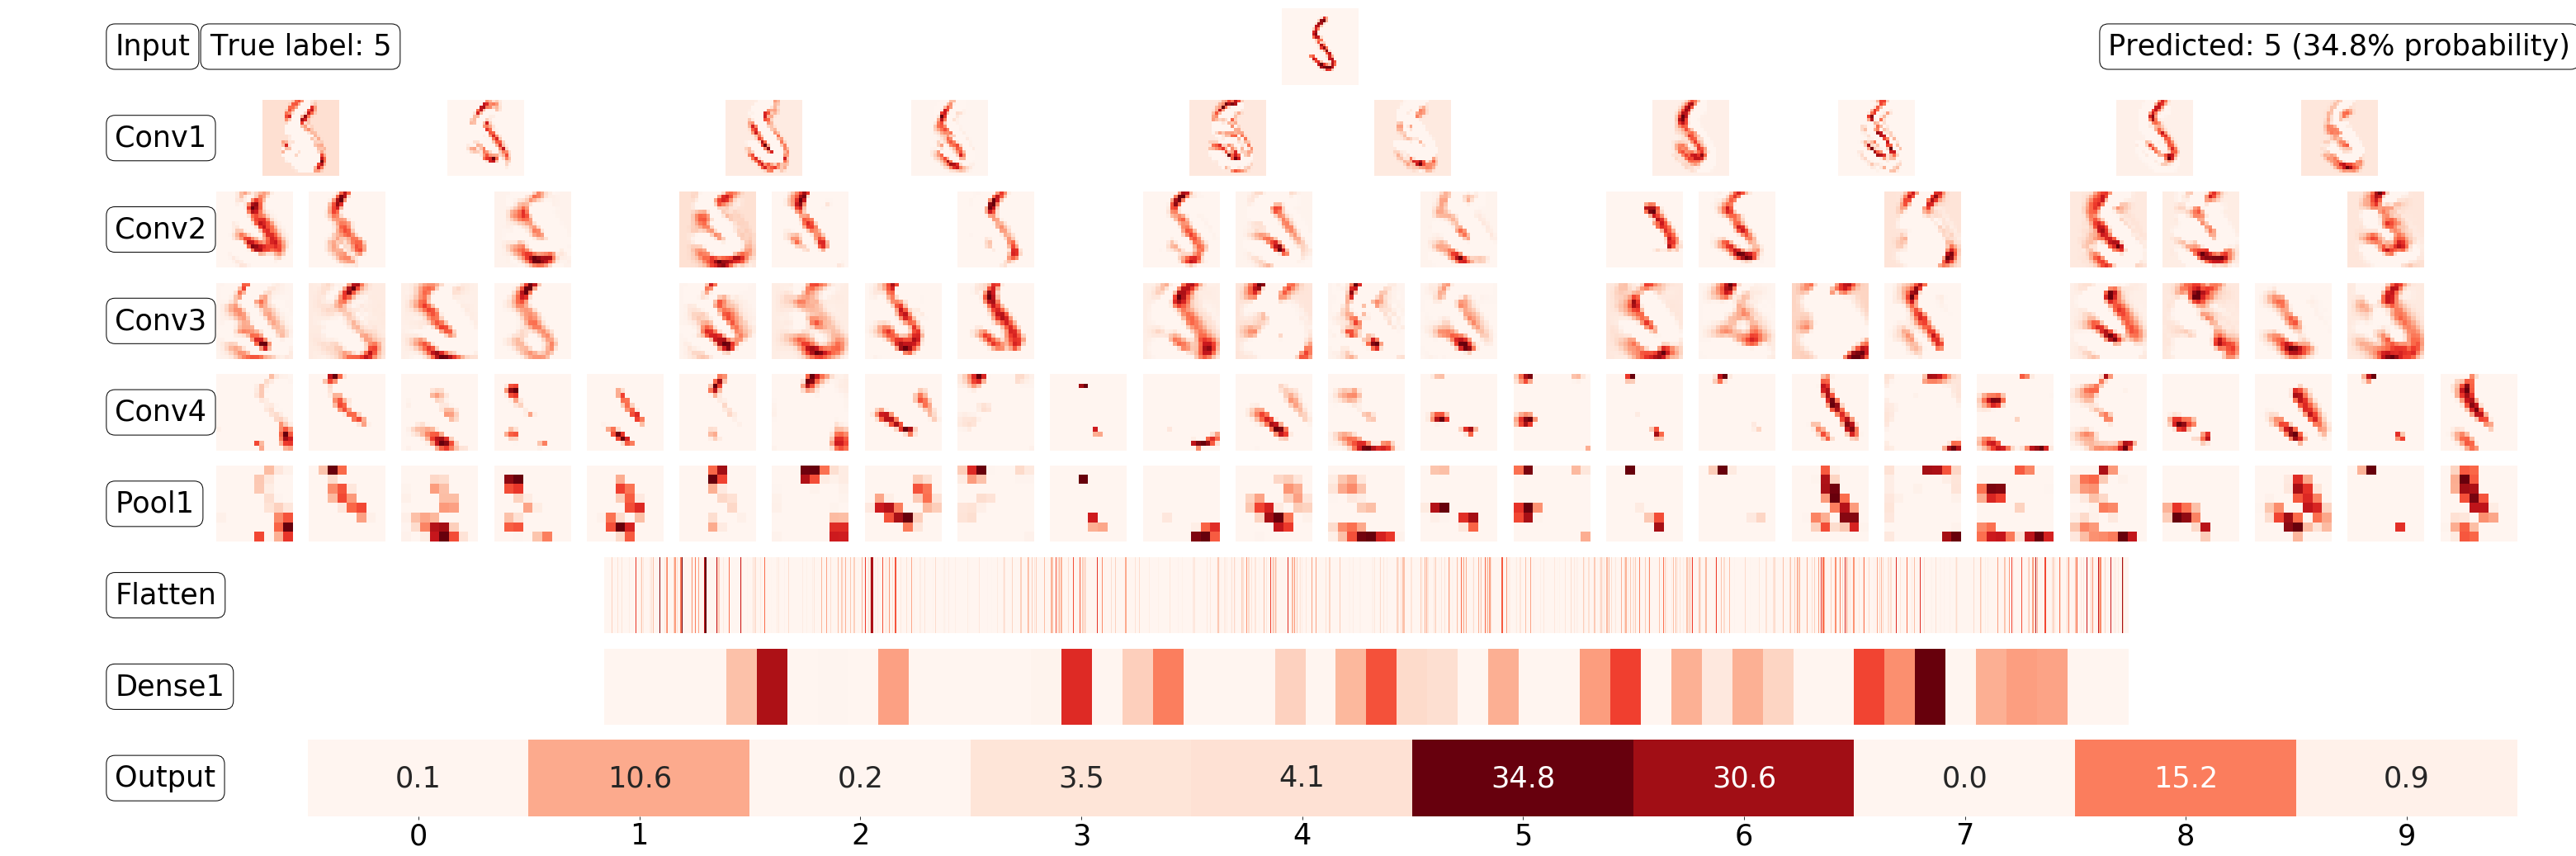

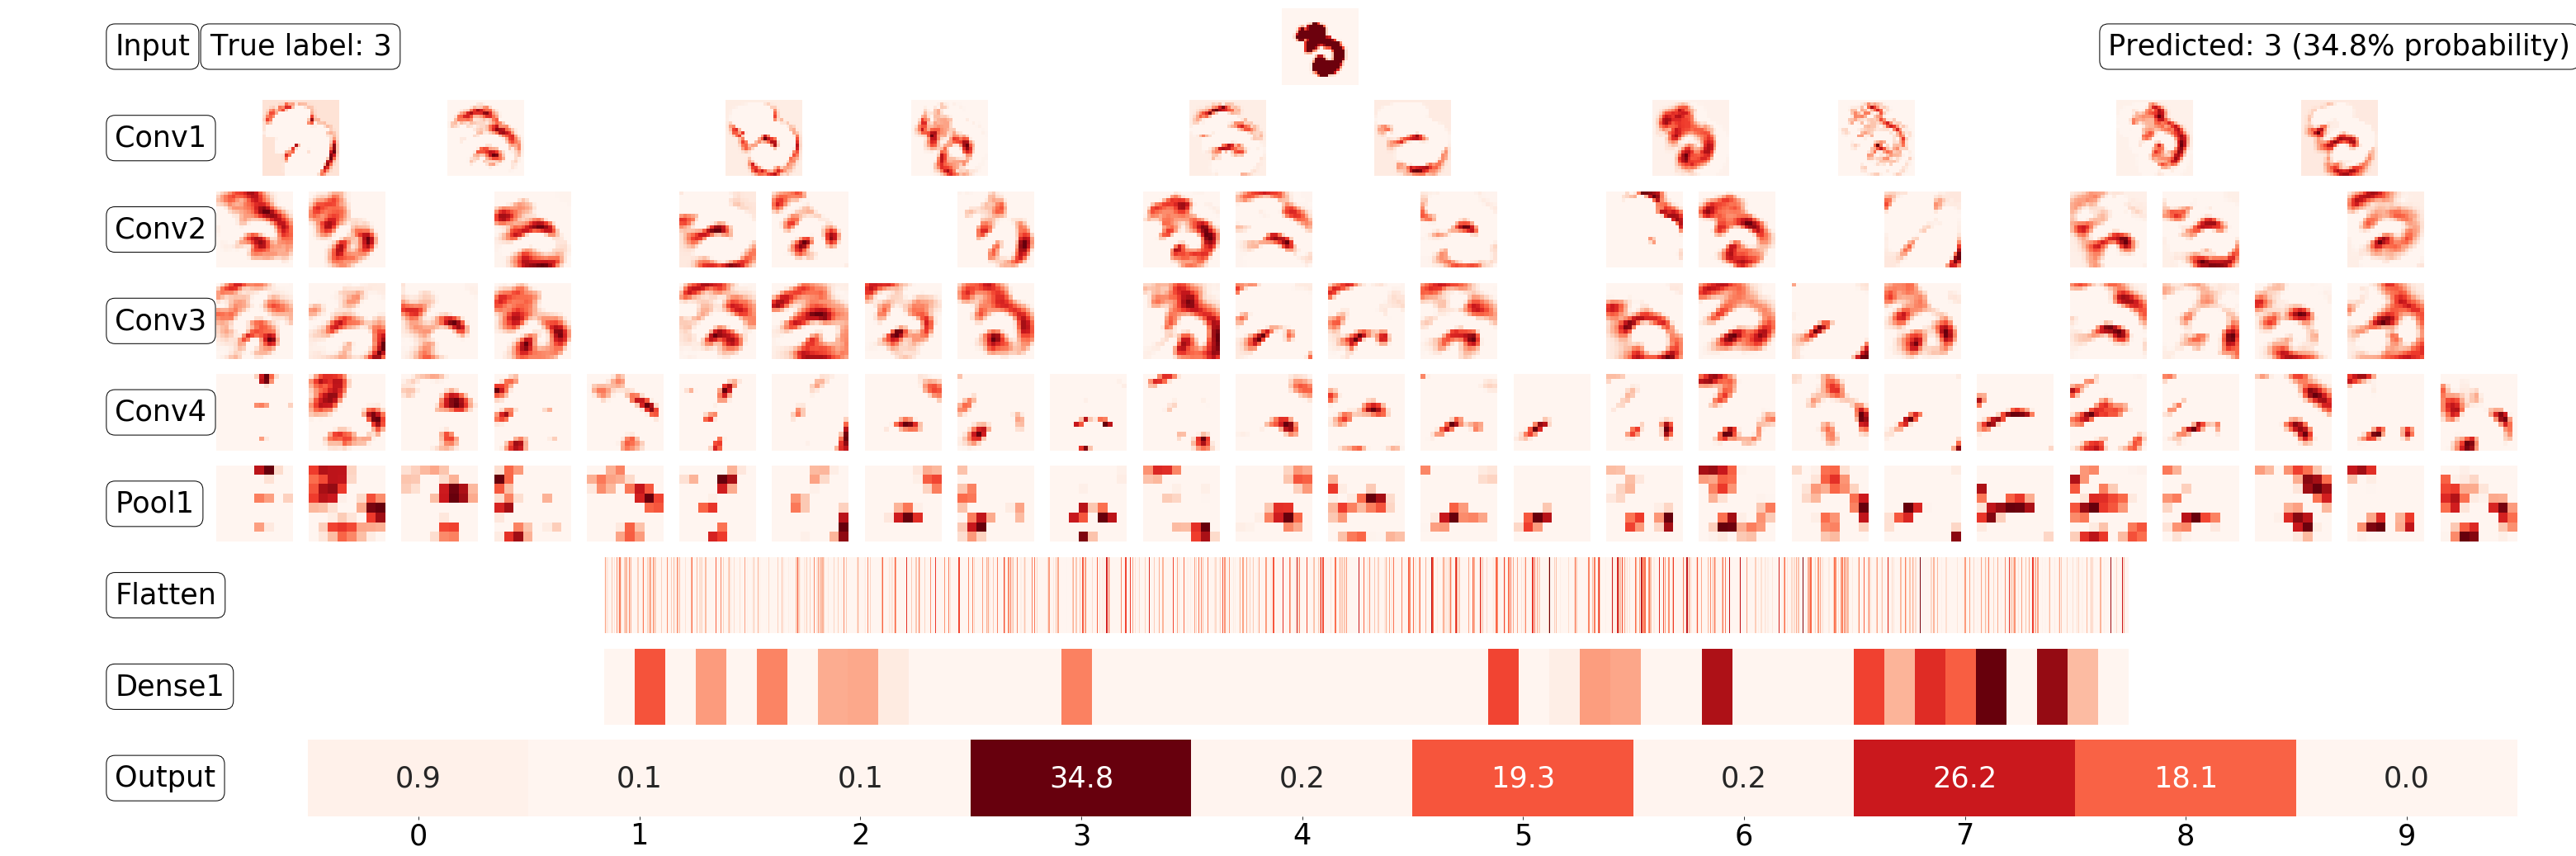

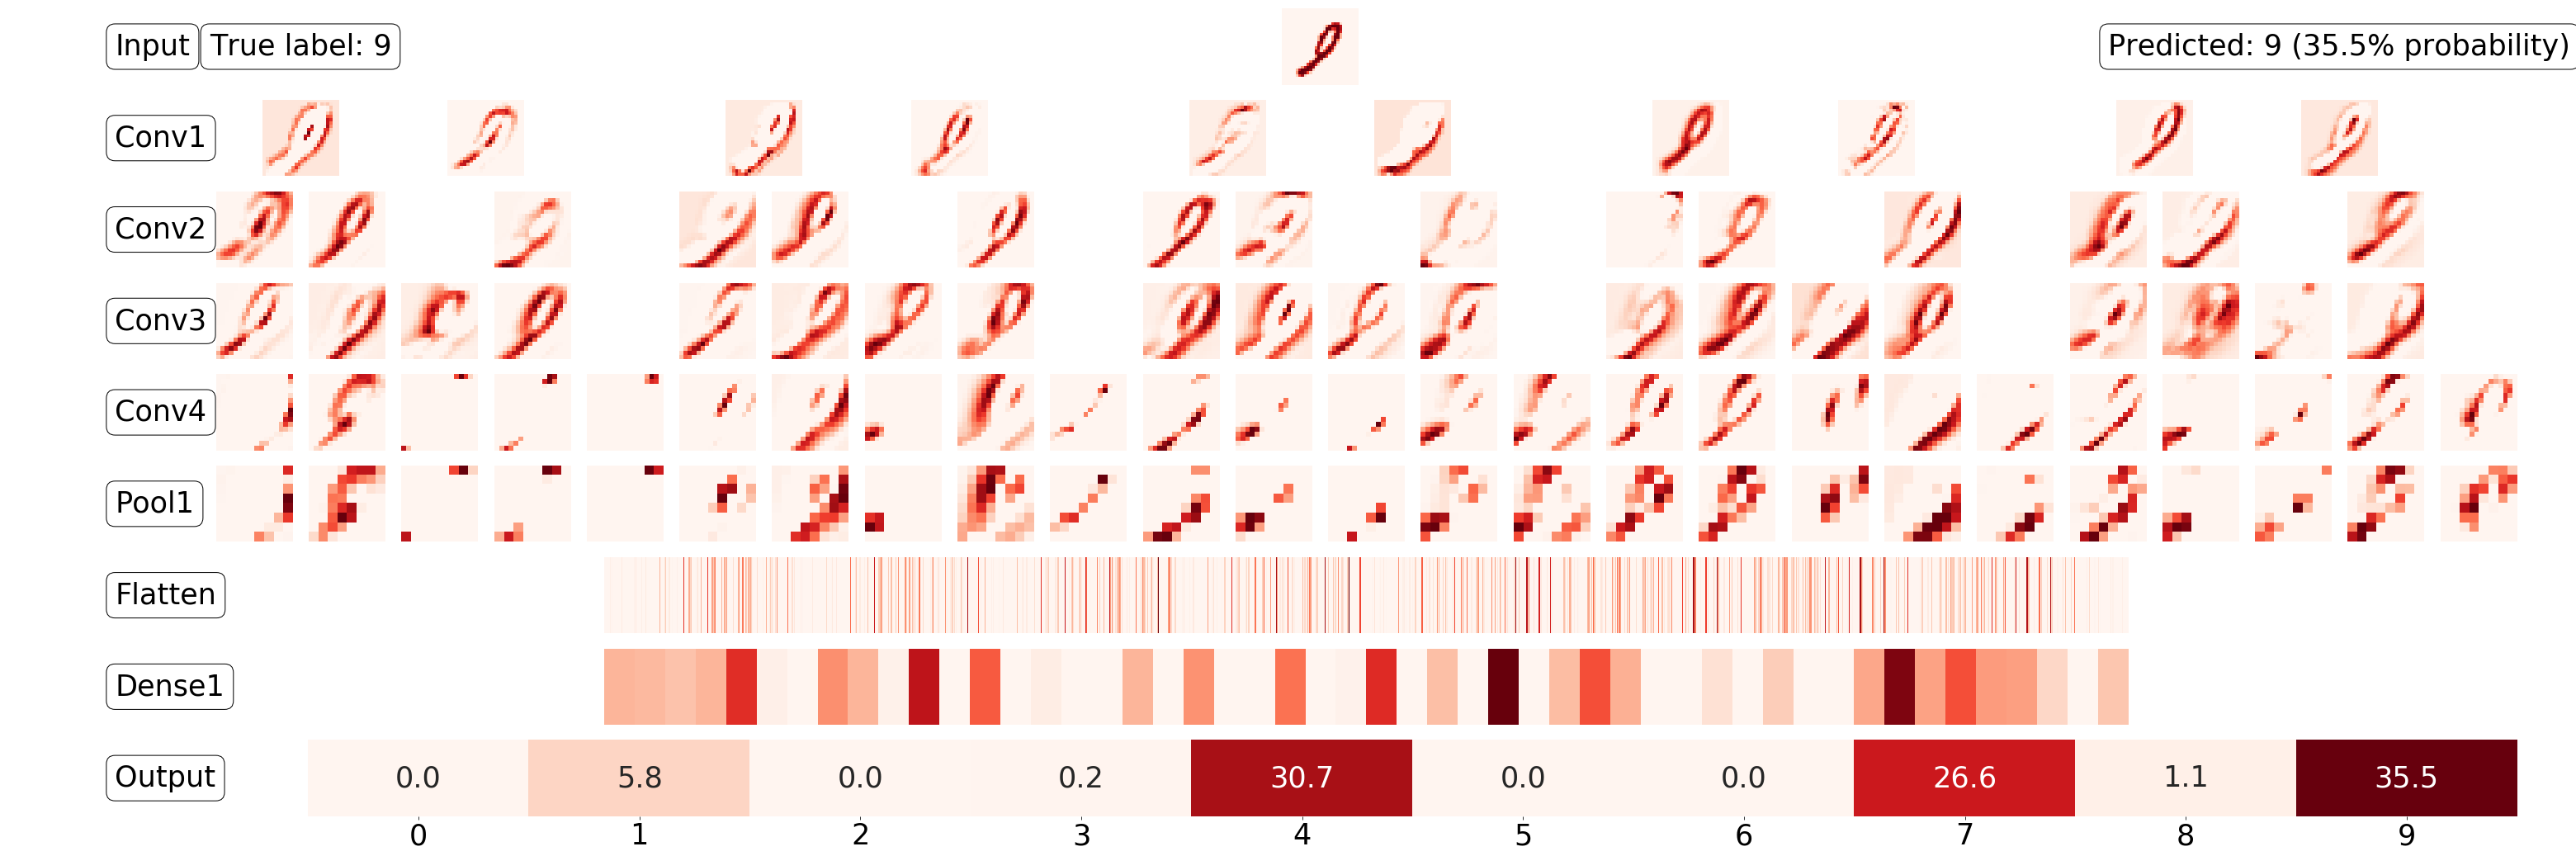

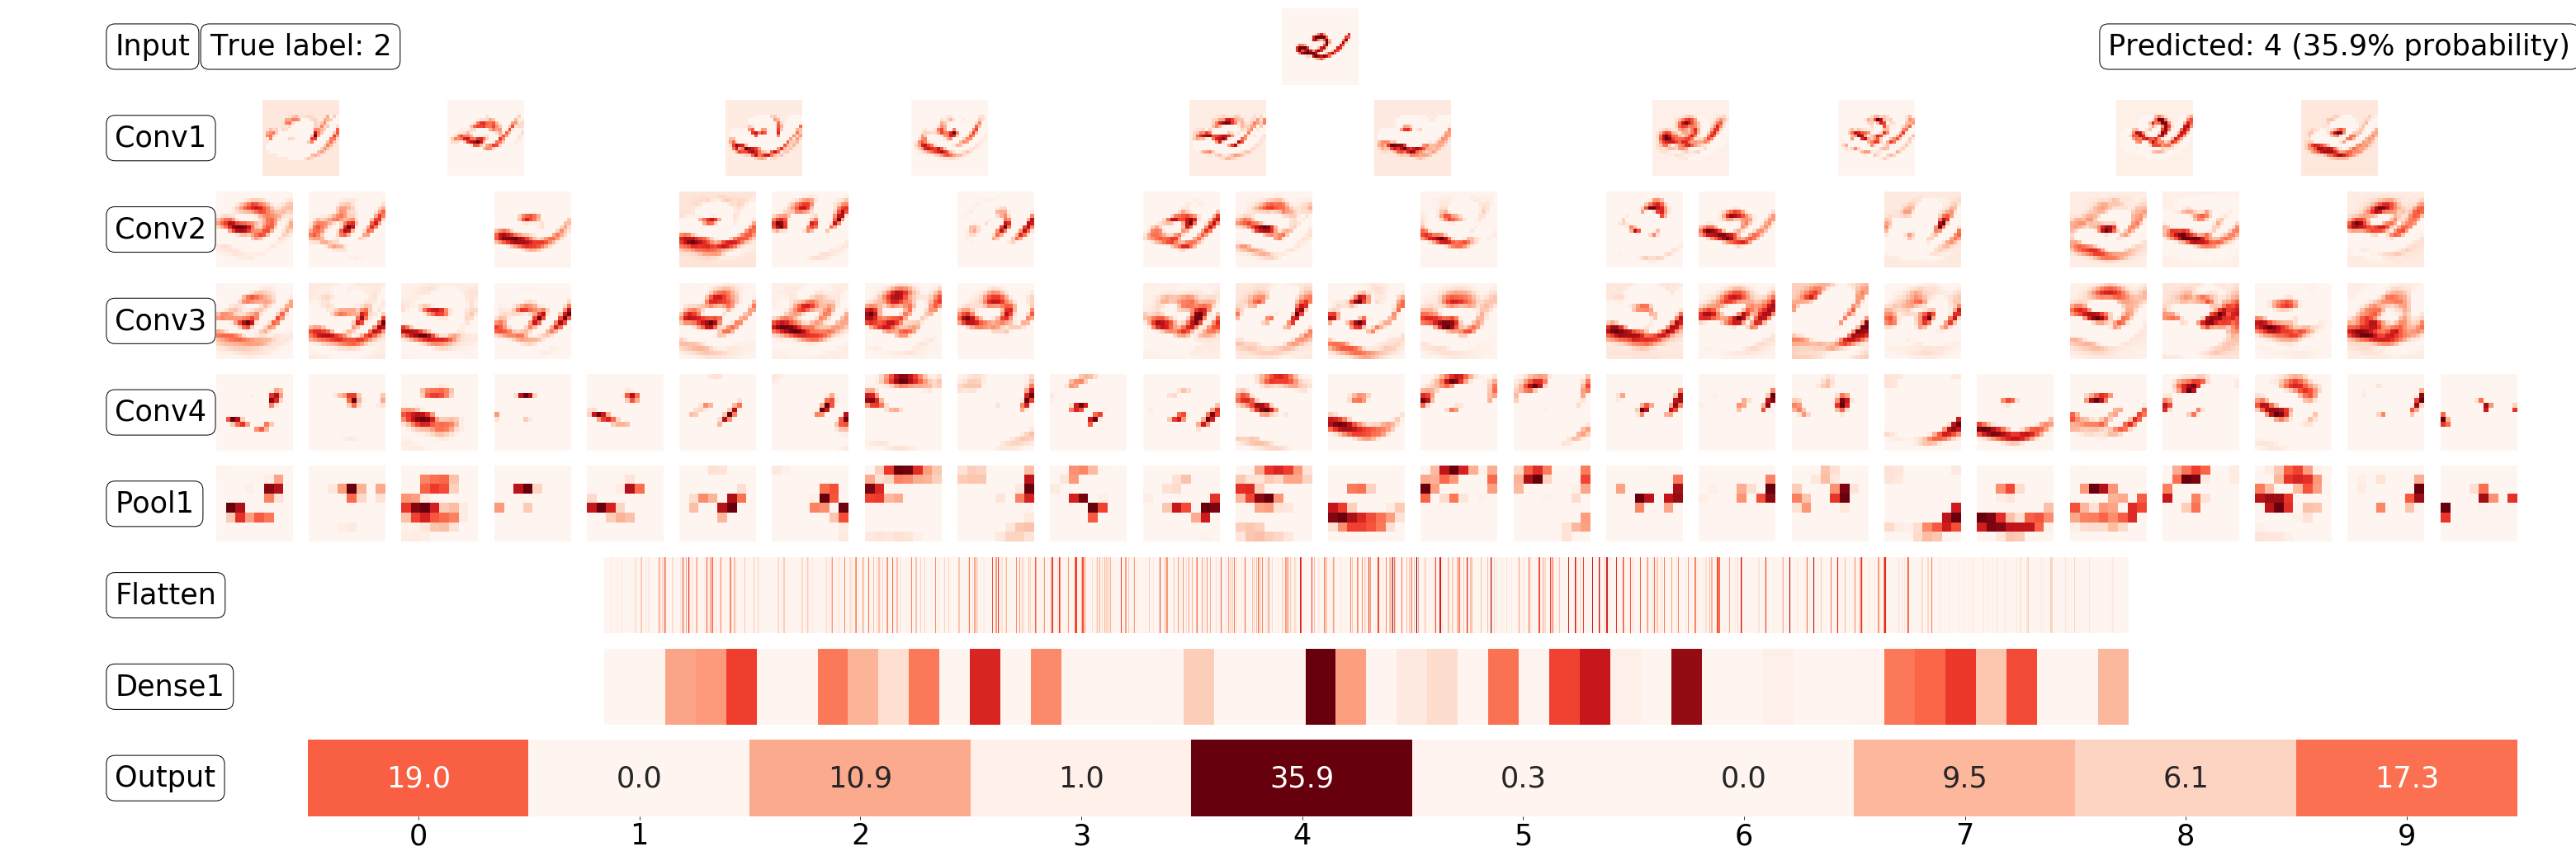

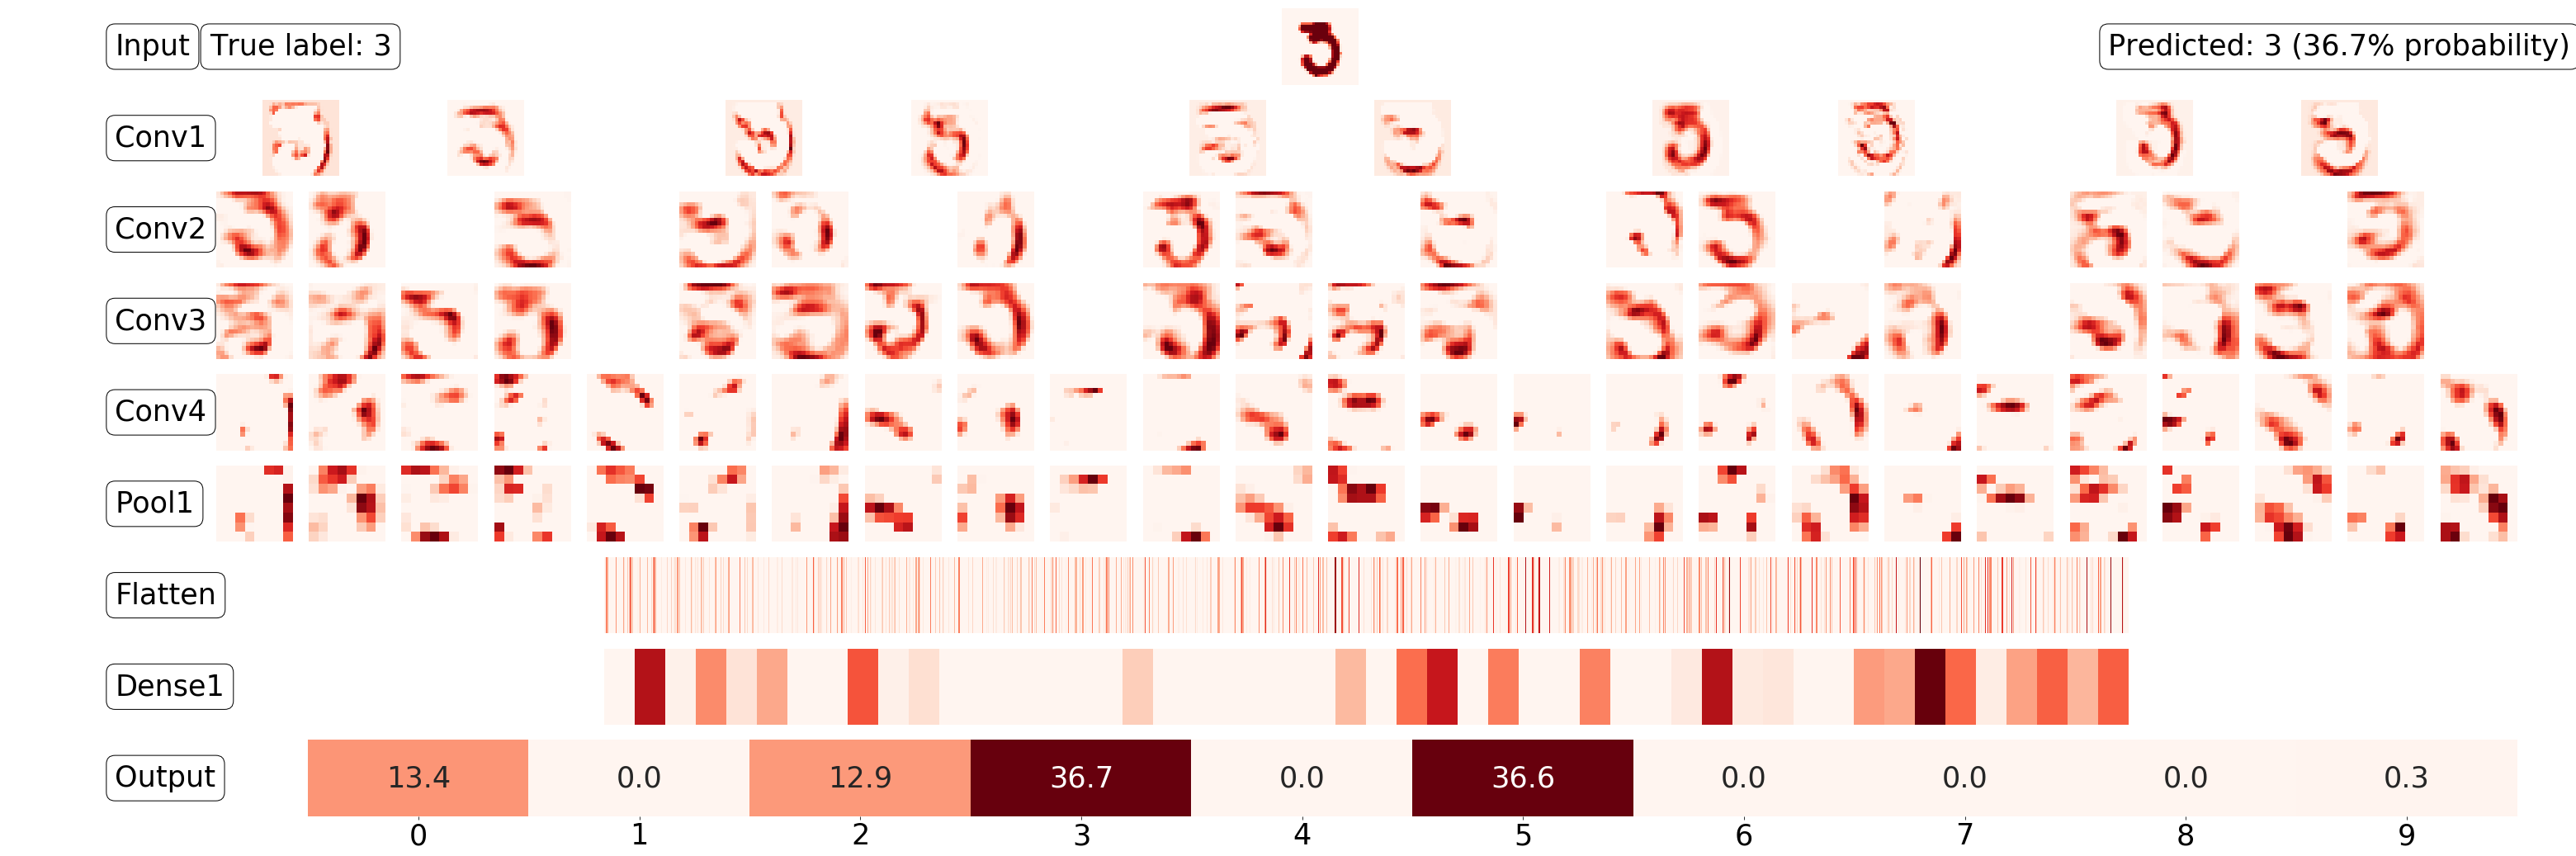

In [10]:
# visualise 10 predictions network is least sure about
worst_pred = layer_out['Output'].max(axis=1).argsort()[:10]

for img_id in worst_pred:
    plot_network(img_id)